In [1]:
import os
import tensorflow as tf
import numpy as np

from transformers import BertTokenizer, TFBertModel
from itertools import combinations



In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
#mpl.use('pgf')
plt.style.use('seaborn-white')

# params = {'text.usetex' : True,
#           'font.size' : 14,
#           'figure.titlesize': 14,
#           'axes.titlesize': 16,
#           'axes.labelsize': 14,
#           'legend.fontsize' : 12,
#           'xtick.labelsize': 12,
#           'ytick.labelsize': 12,
#           'font.family' : 'serif',
#           'text.latex.unicode': True,
#           'axes.grid': False,
#           'axes.labelweight': 'bold',
#          }
# plt.rcParams.update(params)

## Dimension Visualization



In [24]:
COLORS = {'dep distance': 'tab:blue',
          'dep depth': 'lightblue',
          'lex distance': 'tab:green',
          'lex depth': 'lightgreen',
          'pos distance': 'tab:orange',
          'pos depth': 'moccasin',
          'rnd distance': 'tab:grey',
          'rnd depth': 'lightgrey'
         }

def load_ckpt(layer_idx):
    languages = ["en"]
    #out_dir = f'experiments/train_en_tfrecord/task_dep_distance_lex_distance_dep_depth_lex_depth-layer_6-trainl_en'
    #out_dir = f'experiments/combine/task_dep_depth_dep_distance_lex_depth_lex_distance-layer_{layer_idx}-trainl_en'
    out_dir = f'experiments/all/task_dep_depth_dep_distance_lex_depth_lex_distance_pos_depth_pos_distance_rnd_depth_rnd_distance-layer_{layer_idx}-trainl_en'
    #out_dir = f'experiments/task_rnd_depth_rnd_distance-layer_{layer_idx}-trainl_en/'
        
    model_dim = 1024
    probe_rank = 1024


    DistanceProbe = {task: tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5)
                                                        ((1,probe_rank)),
                                                        trainable=False, name=f'{task}_probe', dtype=tf.float32)
                                      for task in ['dep_distance', 'lex_distance', 'pos_distance', 'rnd_distance']}

    DepthProbe = {task: tf.Variable(tf.random_uniform_initializer(minval=-0.5, maxval=0.5)
                                                        ((1, probe_rank)),
                                            trainable=False, name=f'{task}_probe', dtype=tf.float32)
                          for task in ['lex_depth', 'dep_depth', 'pos_depth', 'rnd_depth']}

    optimizer=tf.optimizers.Adam()

    LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                                   trainable=False, name='{}_map'.format(lang))
                                 for lang in languages}


    ckpt = tf.train.Checkpoint(optimizer=optimizer,**DistanceProbe, **DepthProbe, **LanguageMaps)

    checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

    checkpoint_manger.restore_or_initialize()
    
    return ckpt
    
    
def visualize_disentanglement(loadings, task_names, pair_wise=True):

    sorting_array = np.argsort(np.sum(np.array([-1 * (100 ** expon) * np.abs(probe_loadings)
                                       for expon, probe_loadings in zip(np.arange(len(loadings)), loadings)]), axis=0))

    fig, ax = plt.subplots(figsize=[8.5,4])
    for probe_loadings, t_name in zip(loadings, task_names):
        ax.plot(np.abs(probe_loadings[sorting_array]), '.', label=t_name, color=COLORS[t_name])
        ax.legend()
        ax.set_title(f'Layer: {layer_idx + 1}')
    plt.show()
    
    if pair_wise:
        for (pl_a, tn_a), (pl_b, tn_b) in combinations(zip(loadings, task_names), 2):
            sorting_array = np.argsort(-1 *(100 * np.abs(pl_a) + np.abs(pl_b)))
            fig, ax = plt.subplots(figsize=[16,9])
            ax.plot(np.abs(pl_a[sorting_array]), '.', label=tn_a, color=COLORS[tn_a])
            ax.plot(np.abs(pl_b[sorting_array]), '.', label=tn_b, color=COLORS[tn_b])
            ax.legend()
            plt.show()

            
def visualize_histogram(loadings, task_names, pair_wise=True):
    
    sorting_array = np.argsort(np.sum(np.array([-1 * (100 ** expon) * np.abs(probe_loadings)
                                   for expon, probe_loadings in zip(np.arange(len(loadings)), loadings)]), axis=0))

    fig, ax = plt.subplots(figsize=[6,3.5])
    ax.hist([np.where(np.abs(probe_loadings[sorting_array]) > 0.001)[0] for probe_loadings in loadings],
            range=(0,len(sorting_array)), bins=100, stacked=True, alpha=0.9, label=task_names,
           color=[COLORS[tn] for tn in task_names])
    ax.legend()
    ax.set_title(f'Layer: {layer_idx + 1}')
    
    tasks_in_title = '_'.join([ '_'.join(tn.split()) for tn in task_names])
    plt.show()
#     fig.tight_layout()
#     fig.savefig(f'figures/hist_{tasks_in_title}_layer_{layer_idx+1}.pgf', format='pgf')
    
#     if pair_wise:
#         for (pl_a, tn_a), (pl_b, tn_b) in combinations(zip(loadings, task_names), 2):
#             sorting_array = np.argsort(-1 *(100 * np.abs(pl_a) + np.abs(pl_b)))
#             fig, ax = plt.subplots(figsize=[16,9])
#             ax.plot(np.abs(pl_a[sorting_array]), '.', label=tn_a, color=COLORS[tn_a])
#             ax.plot(np.abs(pl_b[sorting_array]), '.', label=tn_b, color=COLORS[tn_b])
#             ax.legend()
#             plt.show()


In [25]:
layer_idx = 6

ckpt = load_ckpt(layer_idx)

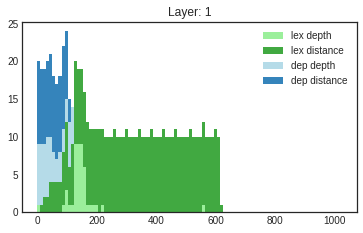

In [28]:
layer_idx = 0

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
dep_depth_probe = ckpt.dep_depth.numpy().ravel()
lex_depth_probe = ckpt.lex_depth.numpy().ravel()
#der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_histogram([lex_depth_probe, lex_distance_probe, dep_depth_probe, dep_distance_probe], 
                              ['lex depth', 'lex distance','dep depth', 'dep distance'])

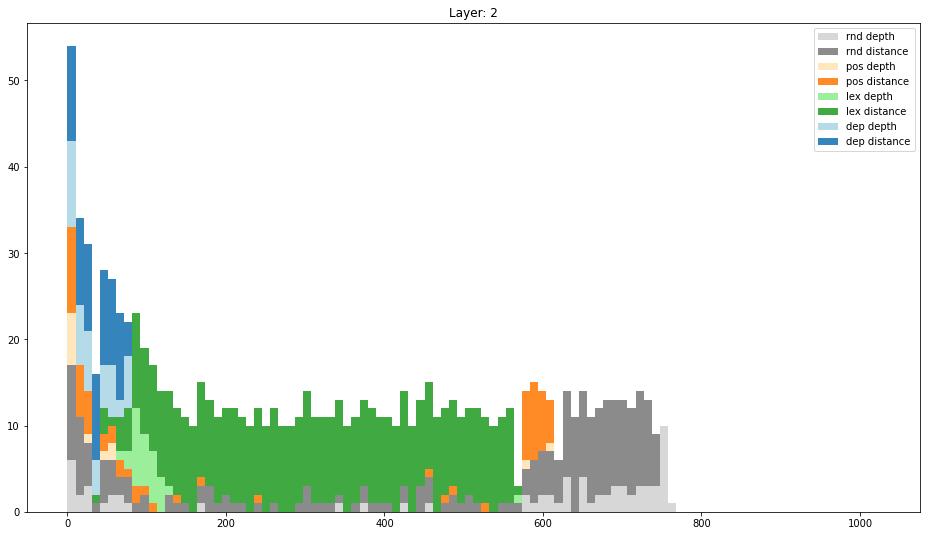

In [78]:
layer_idx = 1

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
pos_distance_probe = ckpt.pos_distance.numpy().ravel()
rnd_distance_probe = ckpt.rnd_distance.numpy().ravel()


dep_depth_probe = ckpt.dep_depth.numpy().ravel()
lex_depth_probe = ckpt.lex_depth.numpy().ravel()
pos_depth_probe = ckpt.pos_depth.numpy().ravel()
rnd_depth_probe = ckpt.rnd_depth.numpy().ravel()
#der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_histogram([rnd_depth_probe, rnd_distance_probe, pos_depth_probe, pos_distance_probe, lex_depth_probe, lex_distance_probe,  dep_depth_probe, dep_distance_probe], 
                              ['rnd depth', 'rnd distance', 'pos depth', 'pos distance', 'lex depth', 'lex distance', 'dep depth', 'dep distance'])

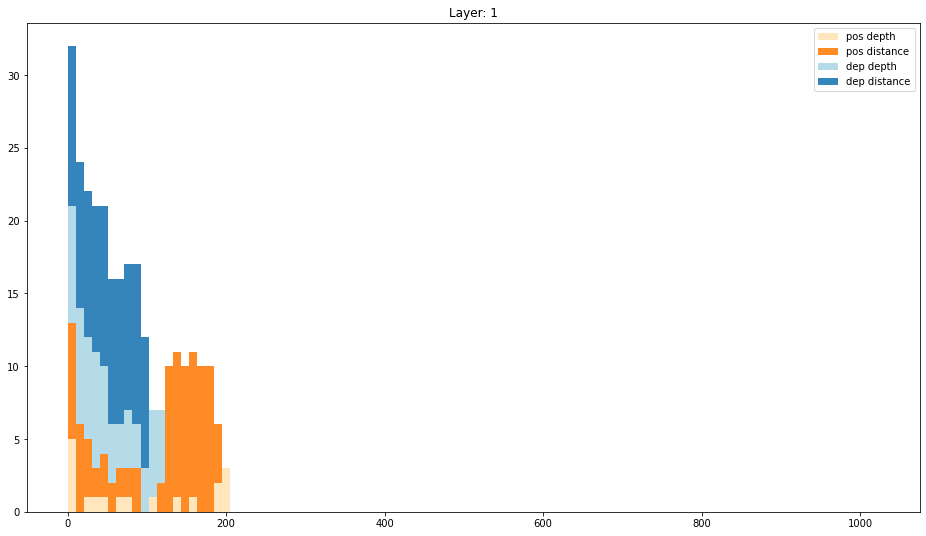

In [79]:
layer_idx = 0

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
pos_distance_probe = ckpt.pos_distance.numpy().ravel()
rnd_distance_probe = ckpt.rnd_distance.numpy().ravel()


dep_depth_probe = ckpt.dep_depth.numpy().ravel()
lex_depth_probe = ckpt.lex_depth.numpy().ravel()
pos_depth_probe = ckpt.pos_depth.numpy().ravel()
rnd_depth_probe = ckpt.rnd_depth.numpy().ravel()
#der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_histogram([pos_depth_probe, pos_distance_probe, dep_depth_probe, dep_distance_probe], 
                              ['pos depth', 'pos distance', 'dep depth', 'dep distance'])

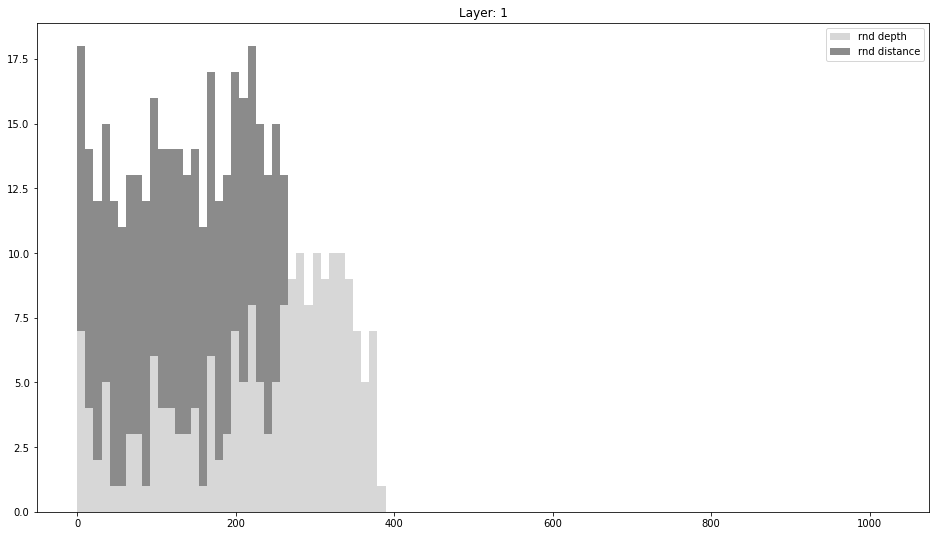

In [61]:
layer_idx = 1

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
pos_distance_probe = ckpt.pos_distance.numpy().ravel()
rnd_distance_probe = ckpt.rnd_distance.numpy().ravel()


dep_depth_probe = ckpt.dep_depth.numpy().ravel()
lex_depth_probe = ckpt.lex_depth.numpy().ravel()
pos_depth_probe = ckpt.pos_depth.numpy().ravel()
rnd_depth_probe = ckpt.rnd_depth.numpy().ravel()
#der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_histogram([rnd_depth_probe, rnd_distance_probe], 
                              ['rnd depth', 'rnd distance'])

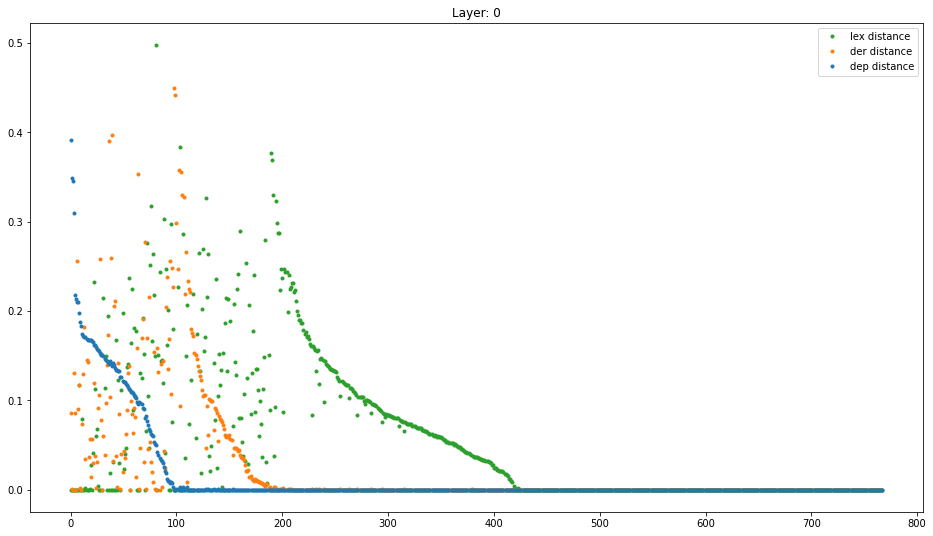

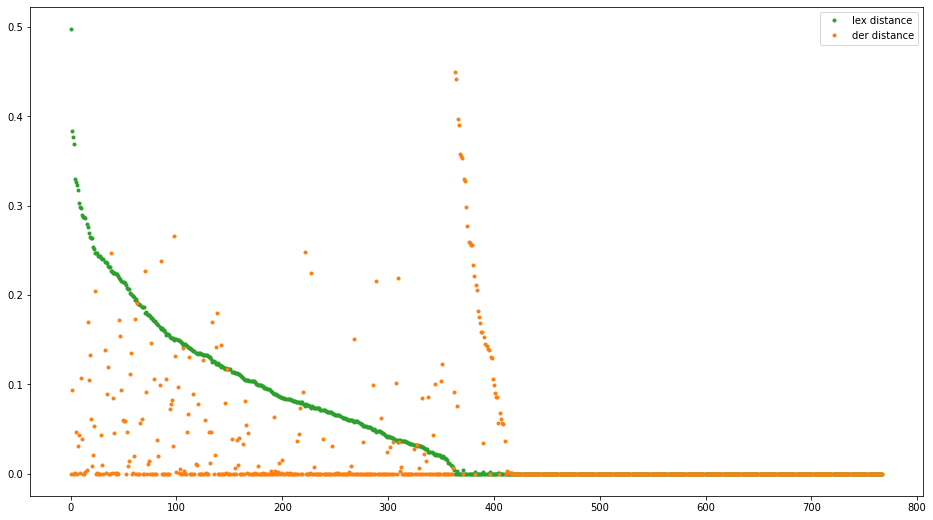

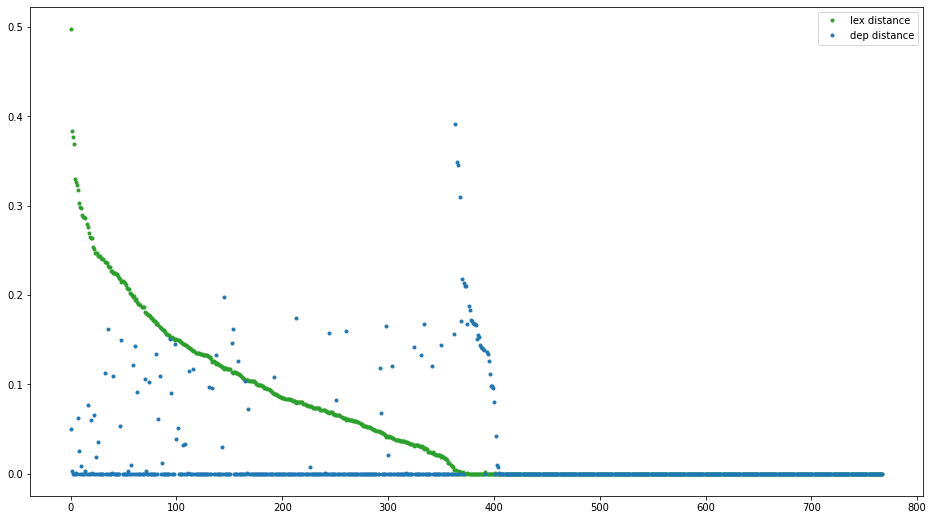

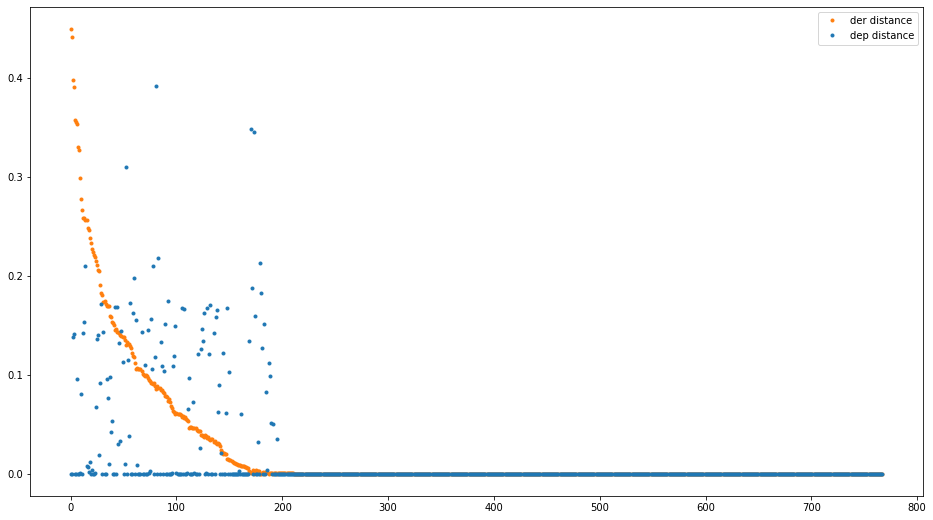

In [348]:
layer_idx = 0

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance', 'der distance','dep distance'])

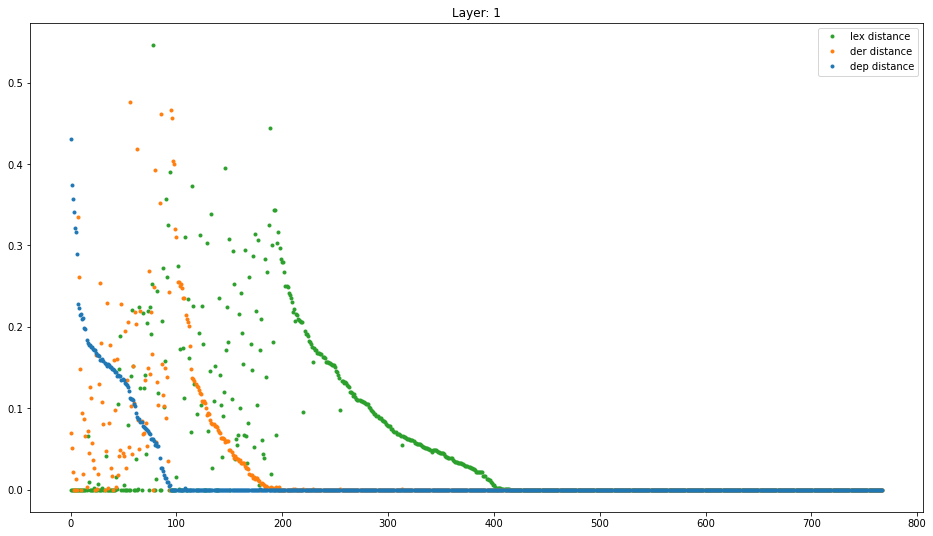

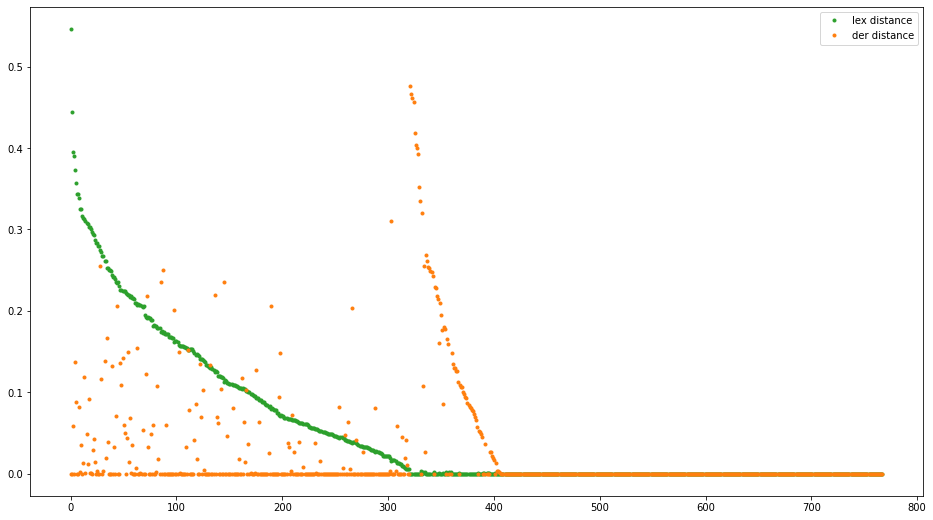

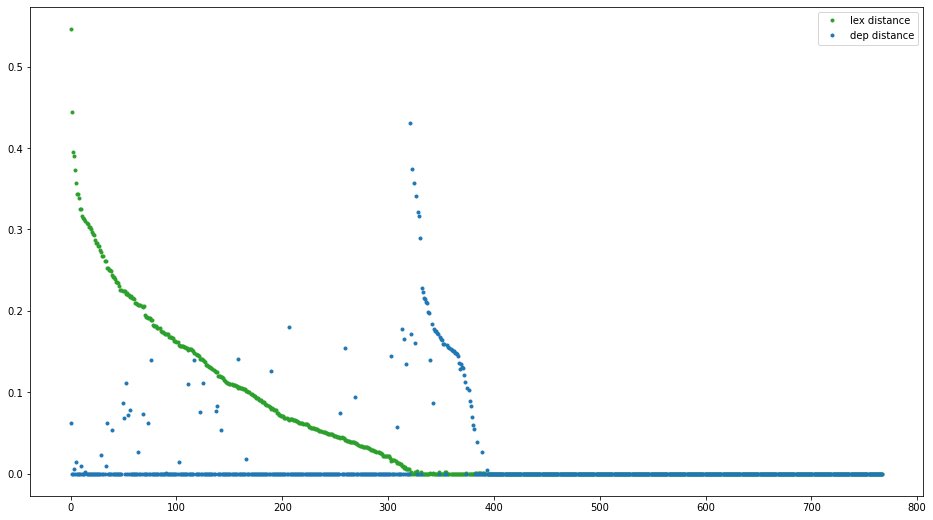

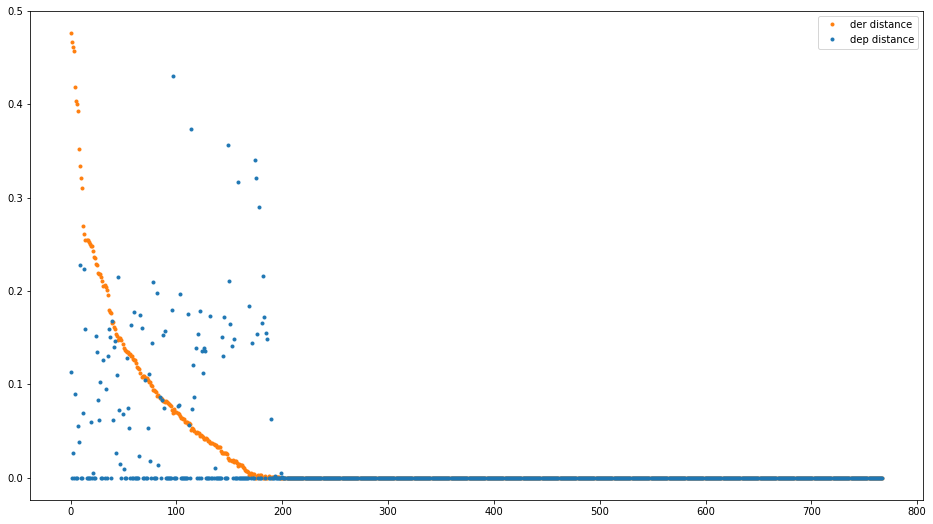

In [349]:
layer_idx = 1

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance', 'der distance','dep distance'])

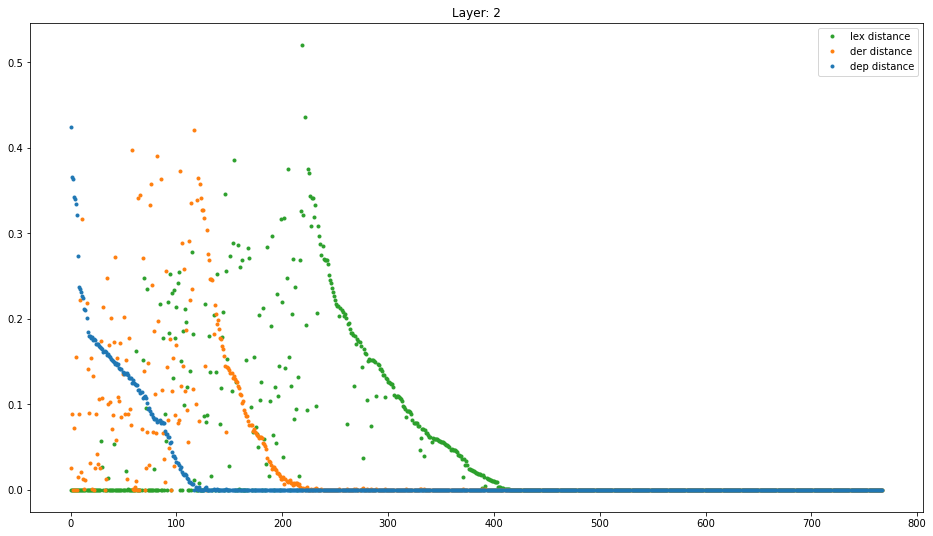

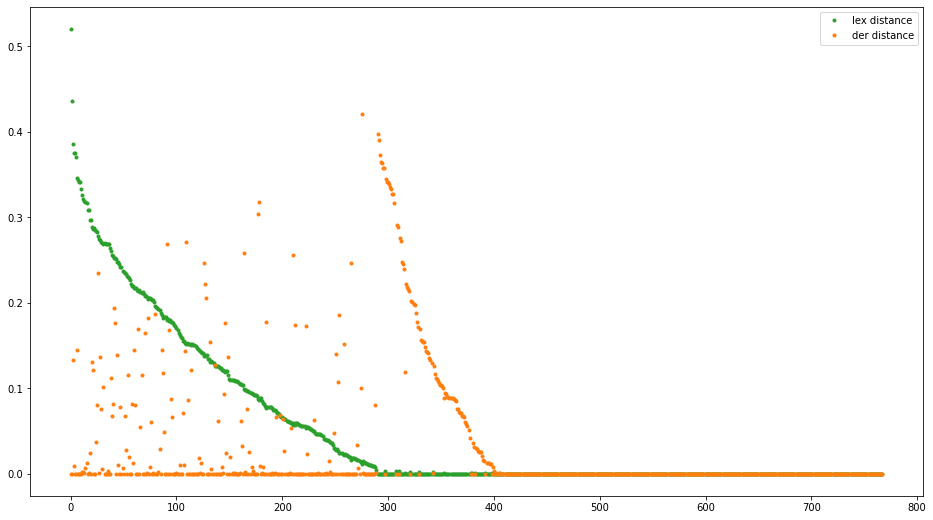

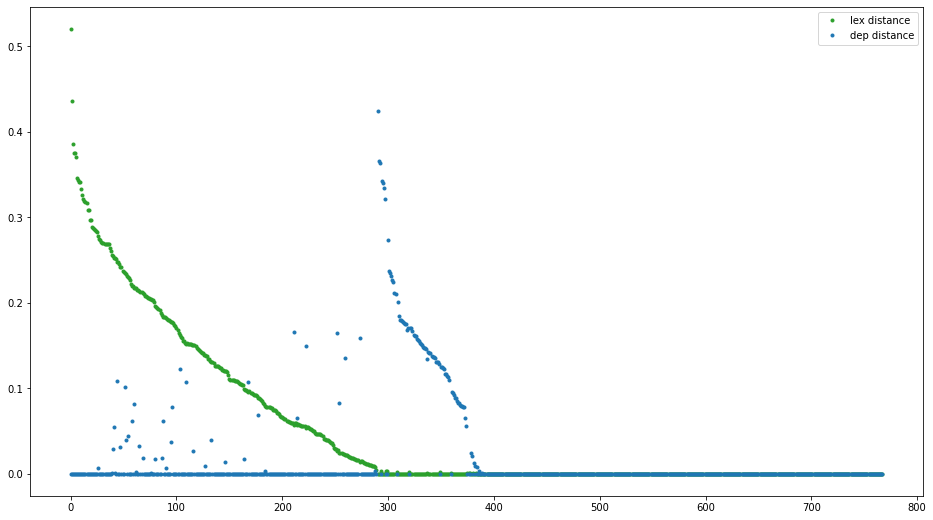

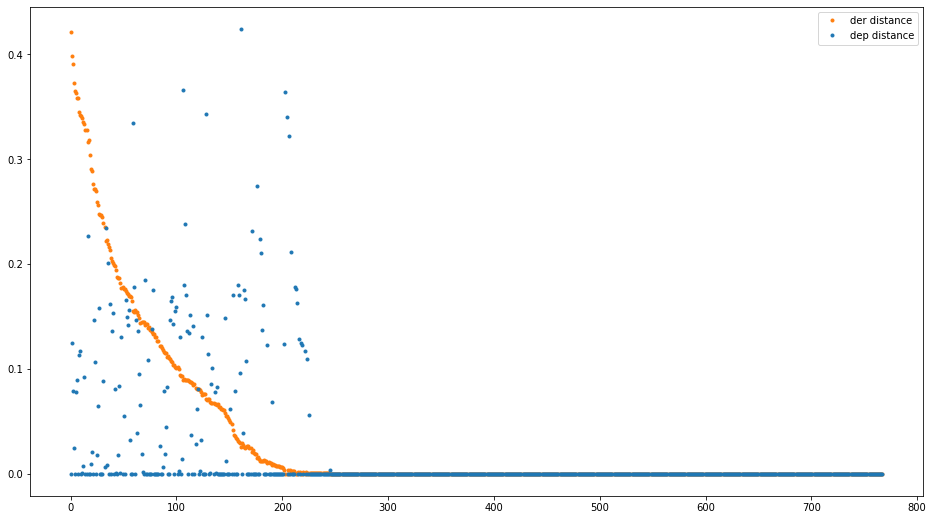

In [350]:
layer_idx = 2

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance', 'der distance','dep distance'])

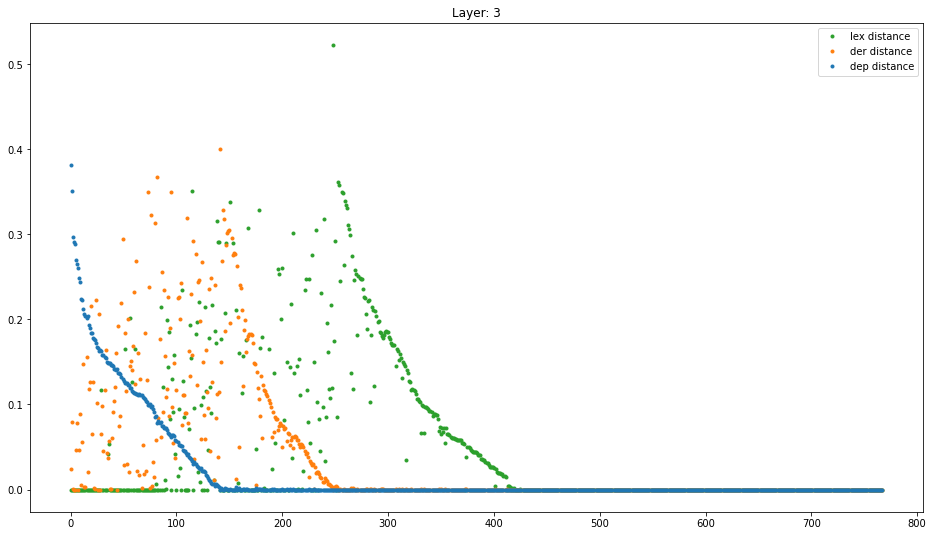

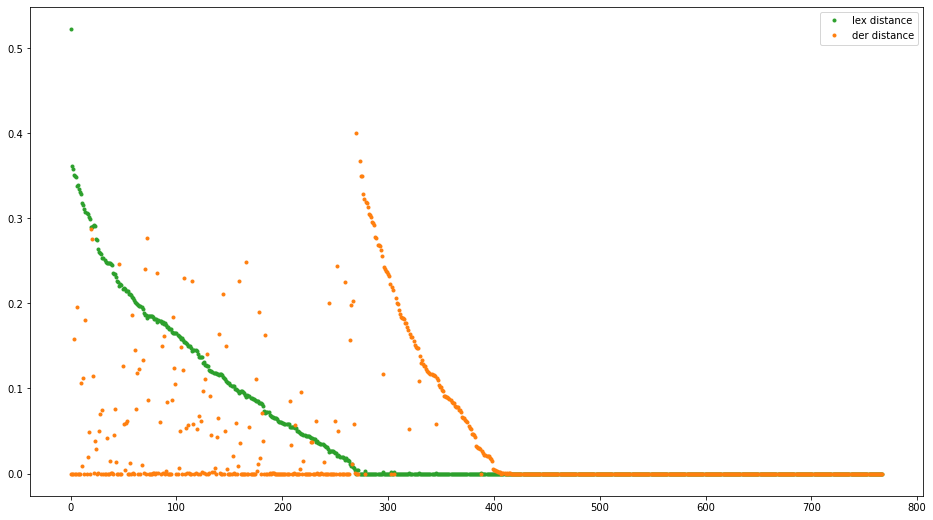

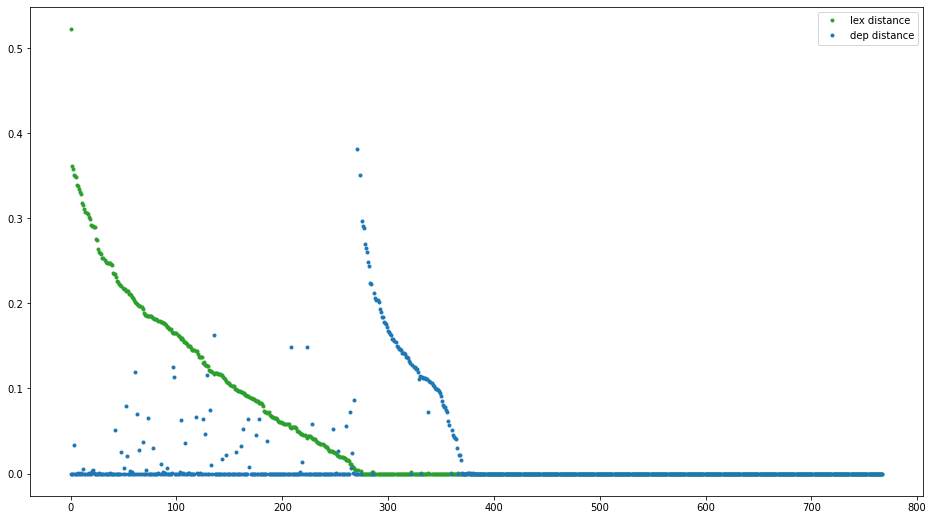

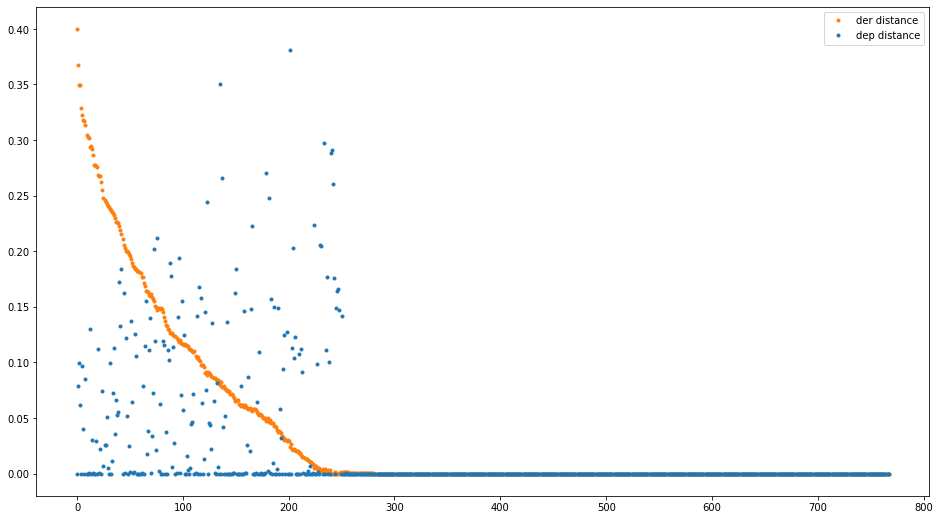

In [351]:
layer_idx = 3

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance', 'der distance','dep distance'])

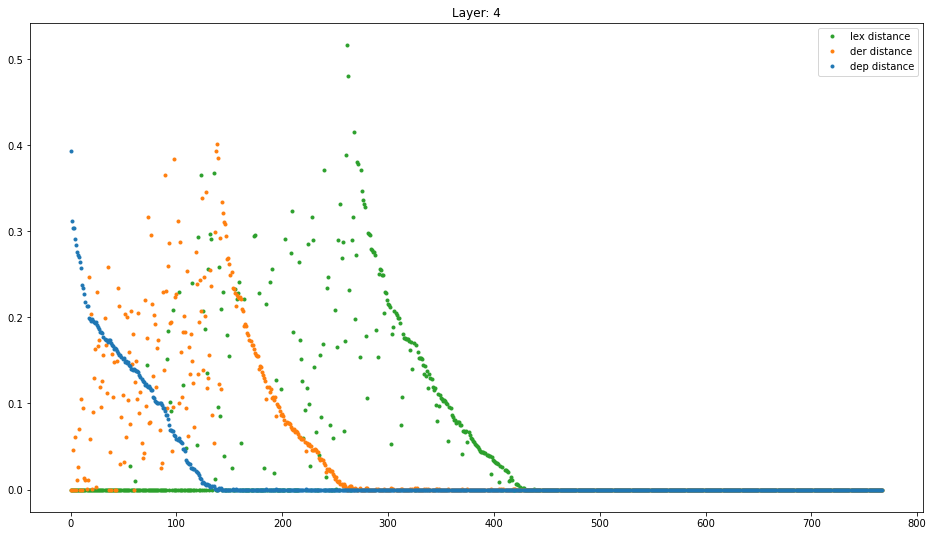

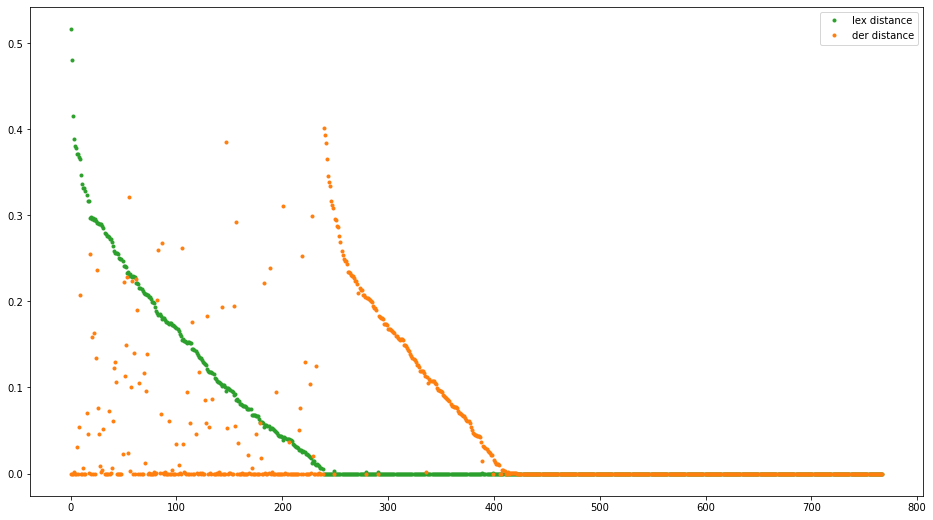

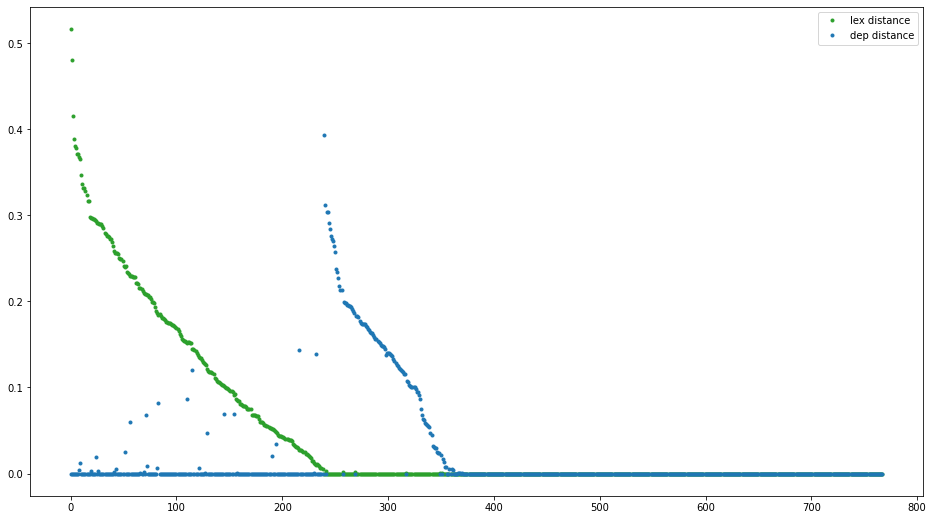

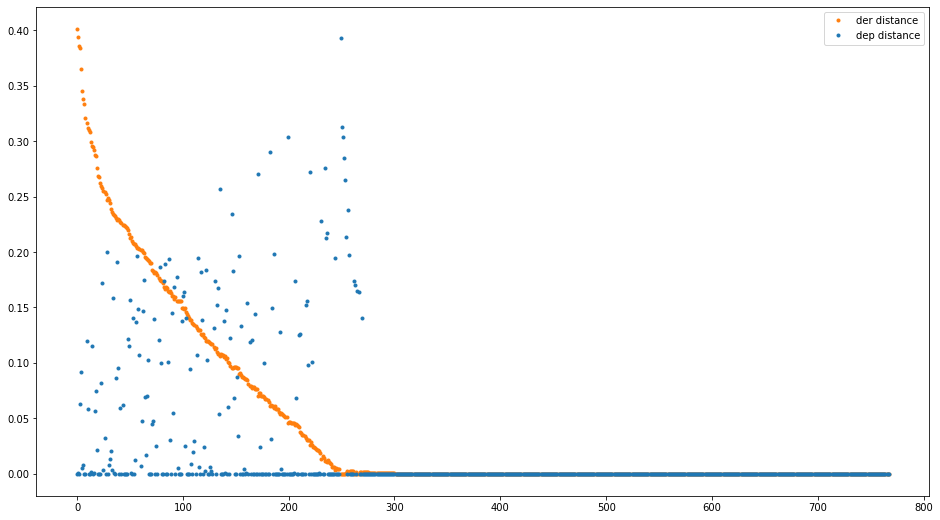

In [352]:
layer_idx = 4

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance', 'der distance','dep distance'])

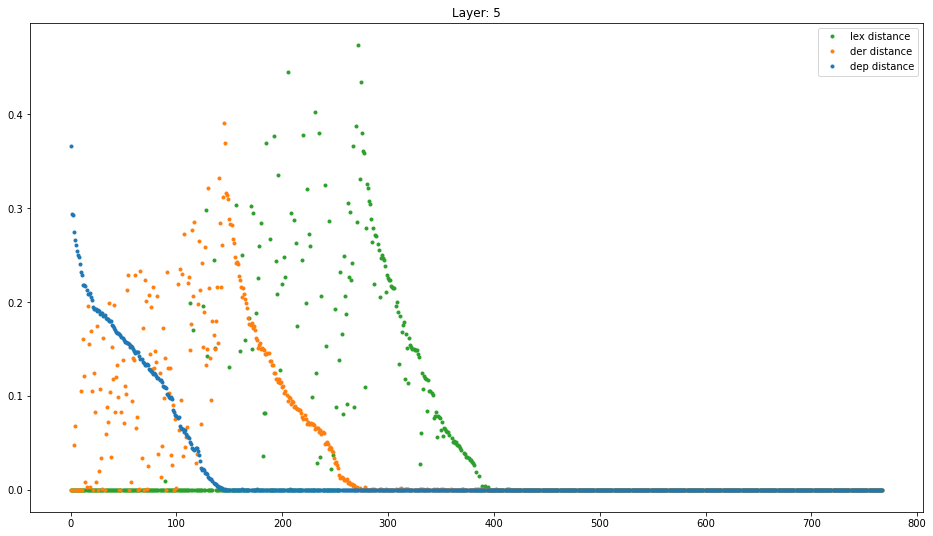

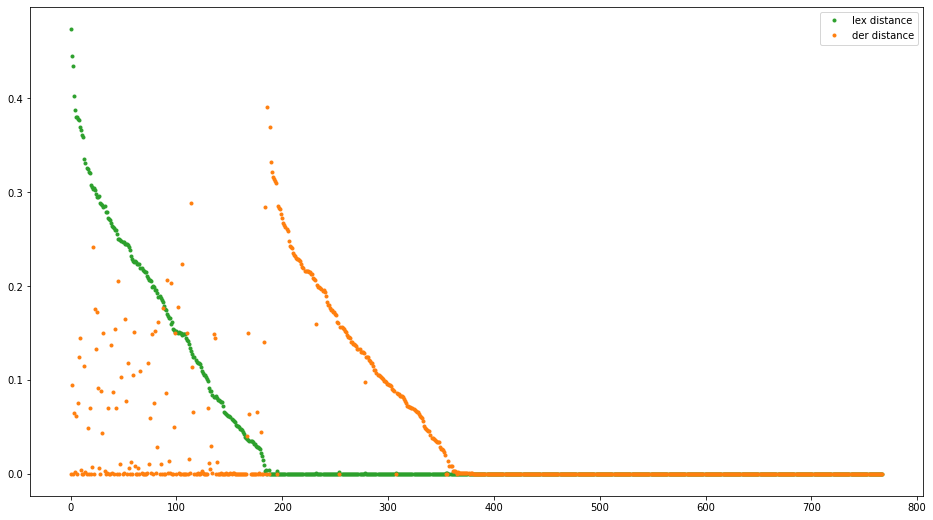

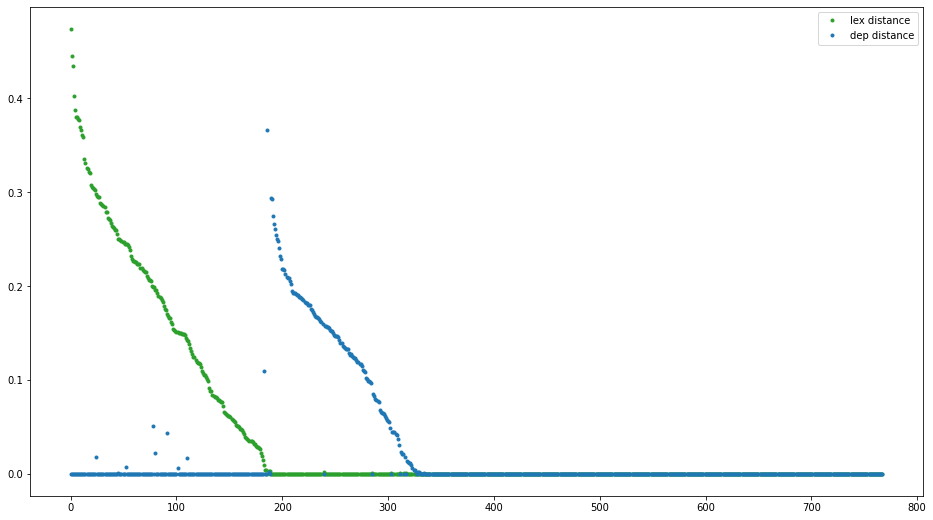

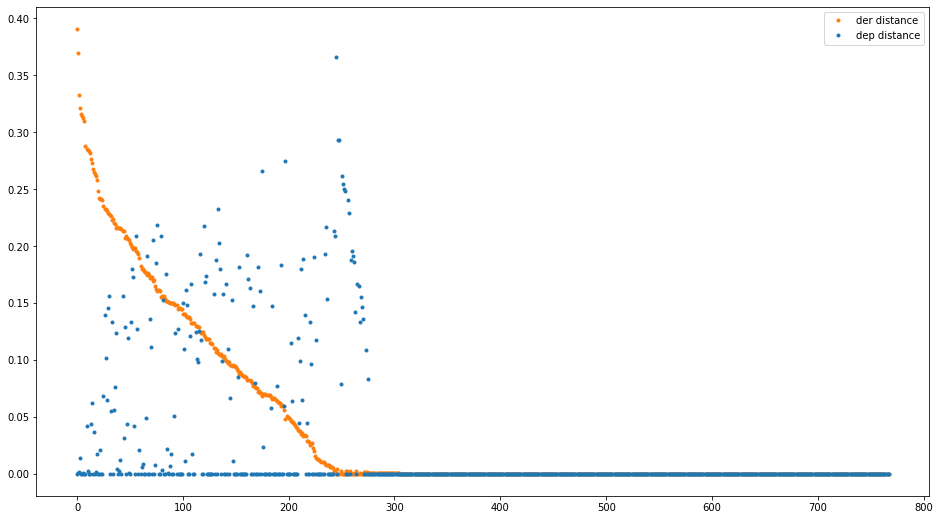

In [353]:
layer_idx = 5

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance', 'der distance','dep distance'])

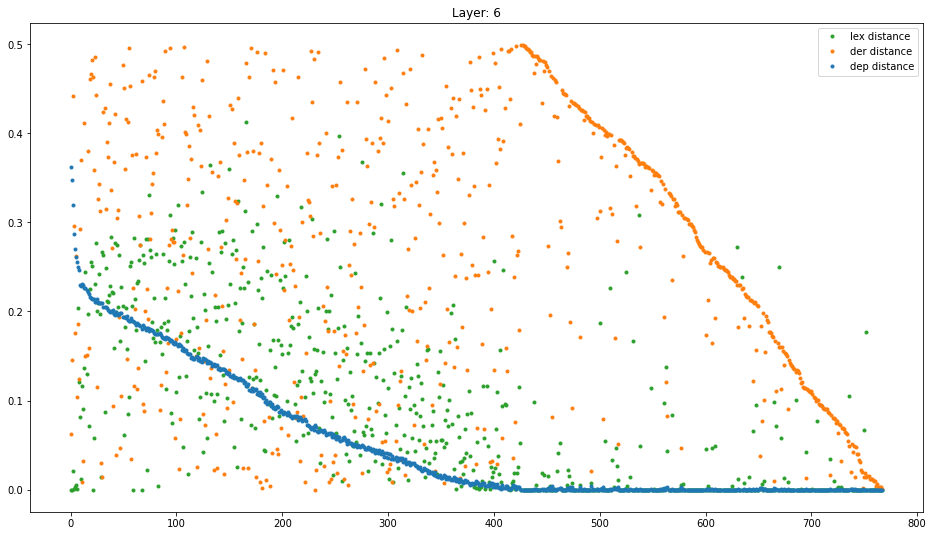

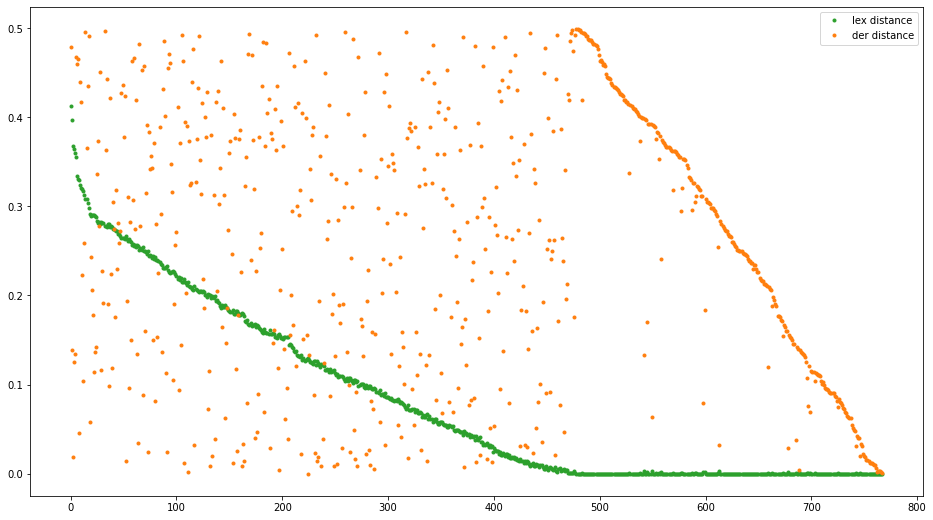

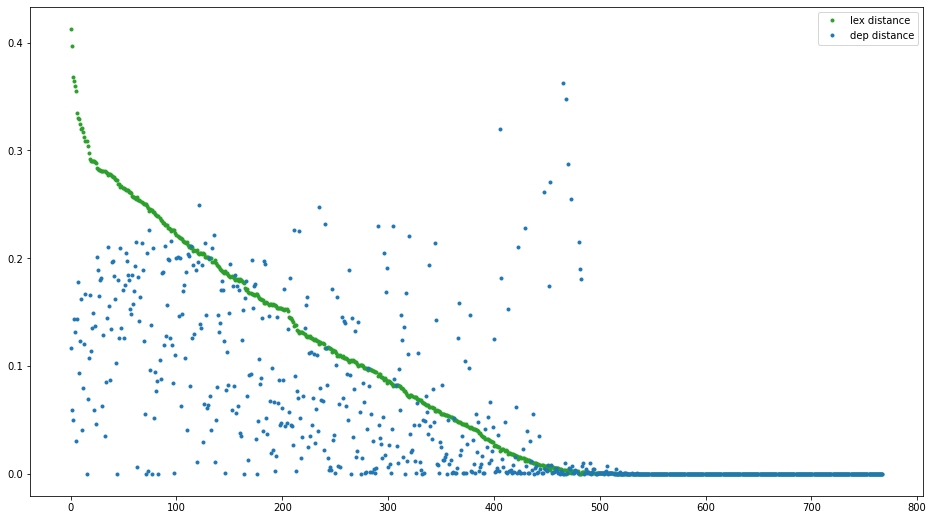

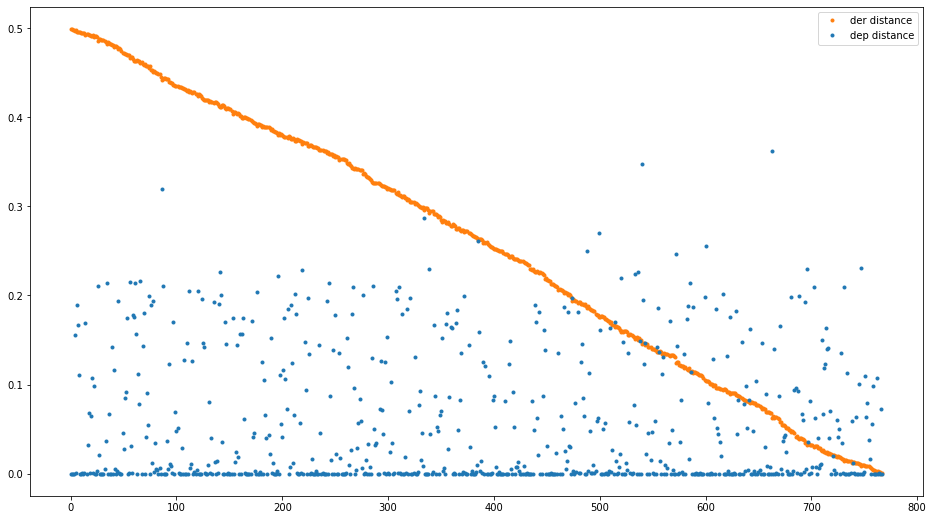

In [32]:
 layer_idx = 6

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance','der distance', 'dep distance'])

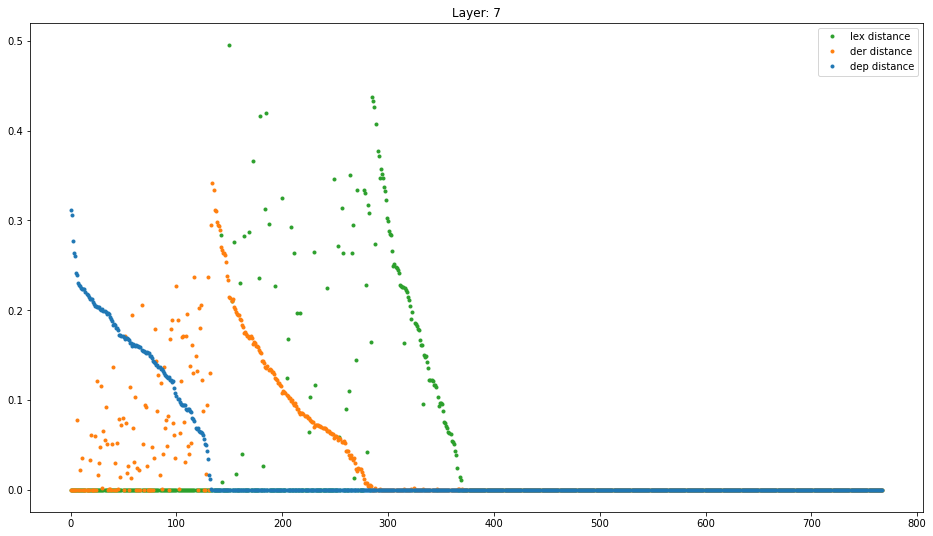

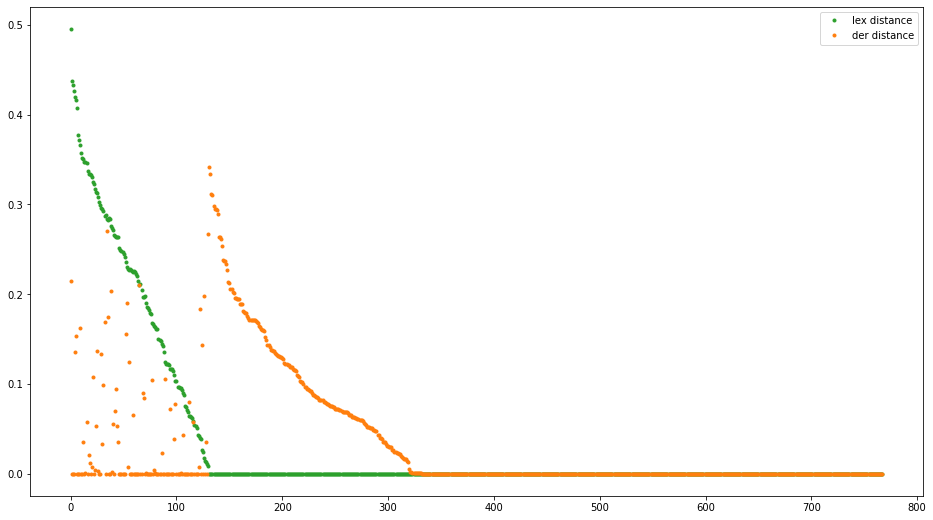

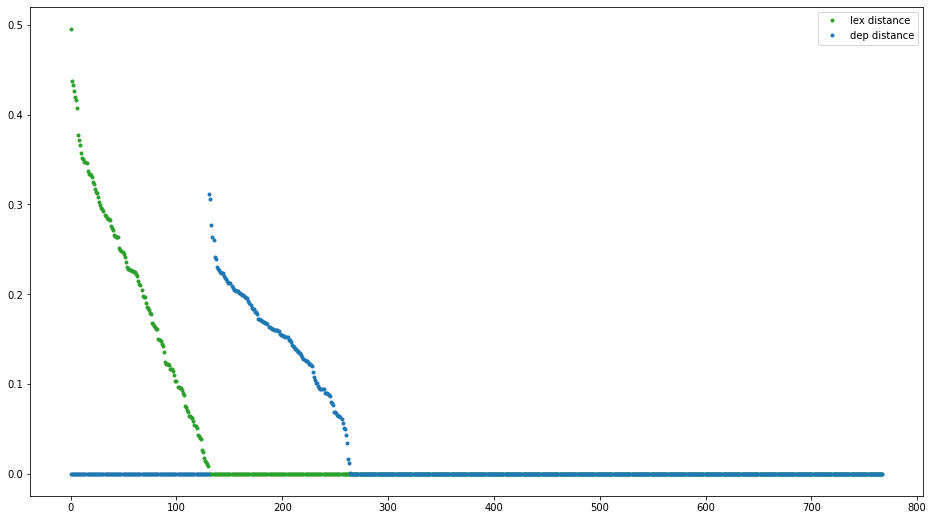

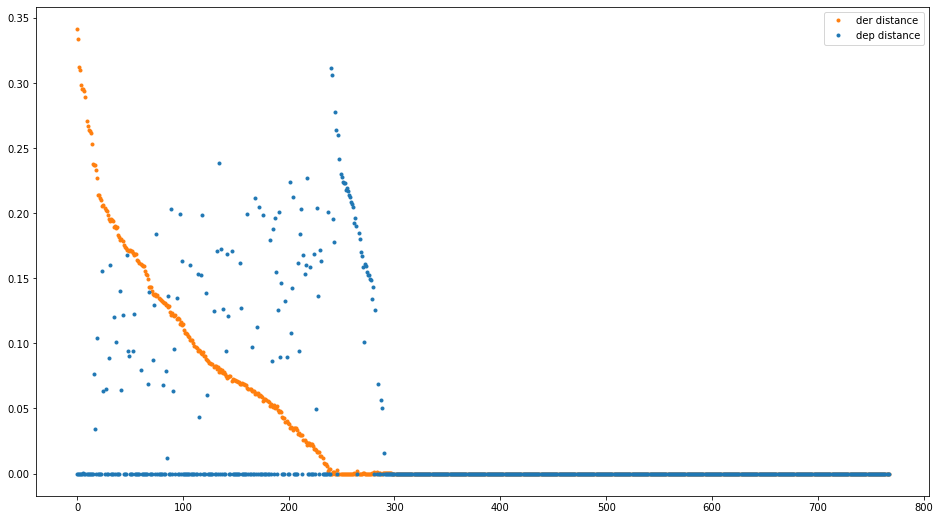

In [355]:
 layer_idx = 7

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance','der distance', 'dep distance'])

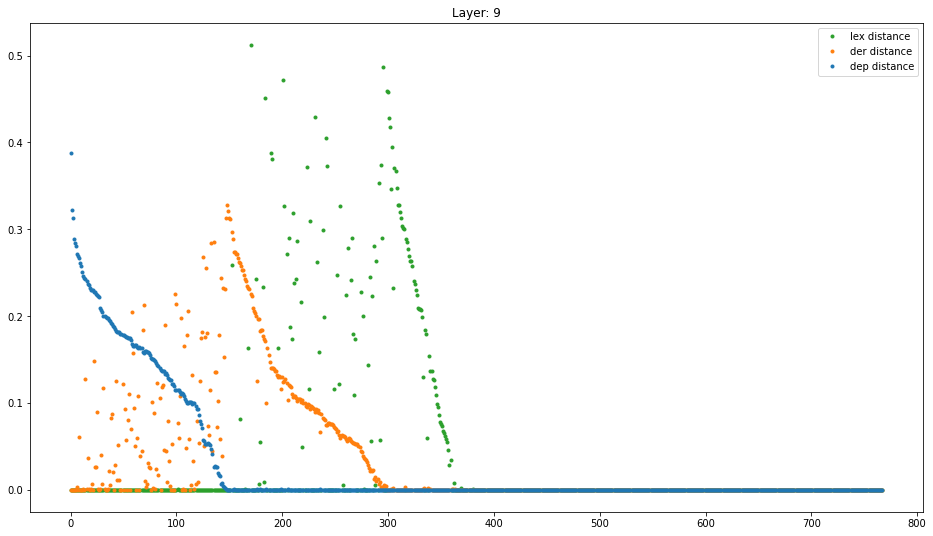

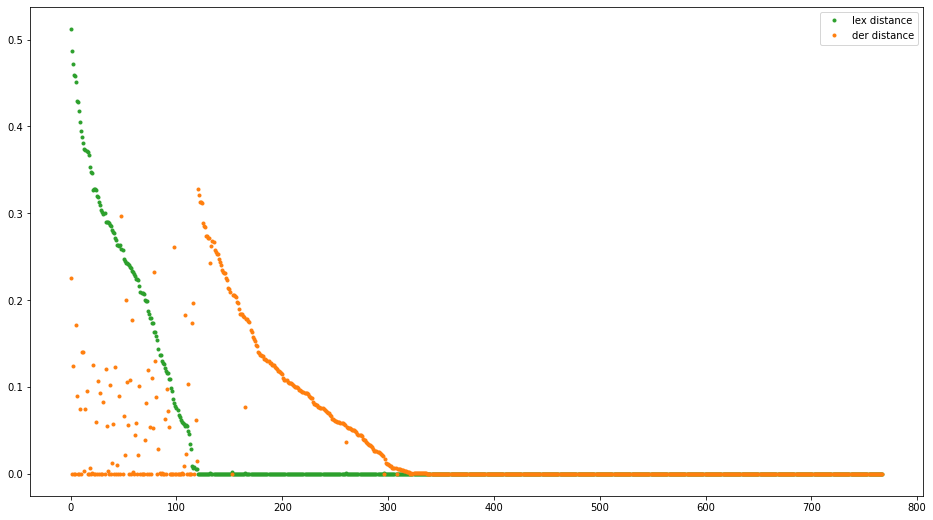

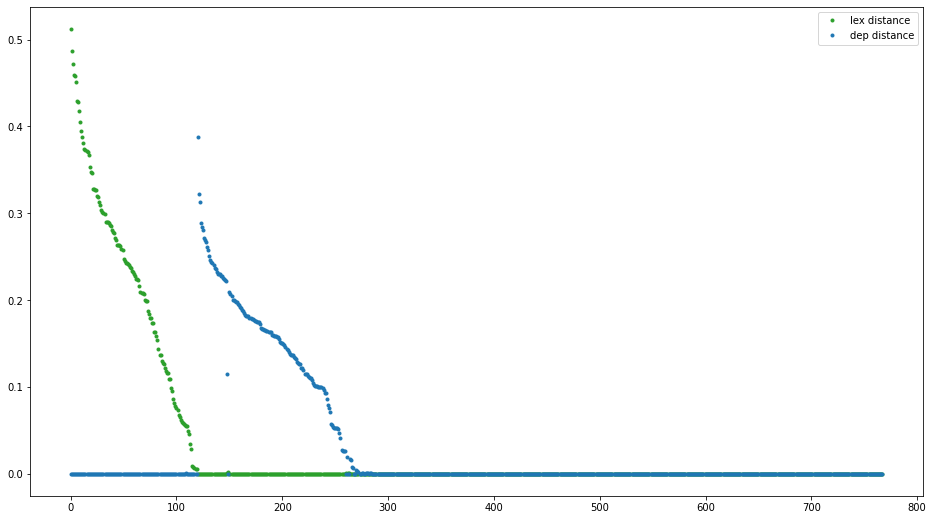

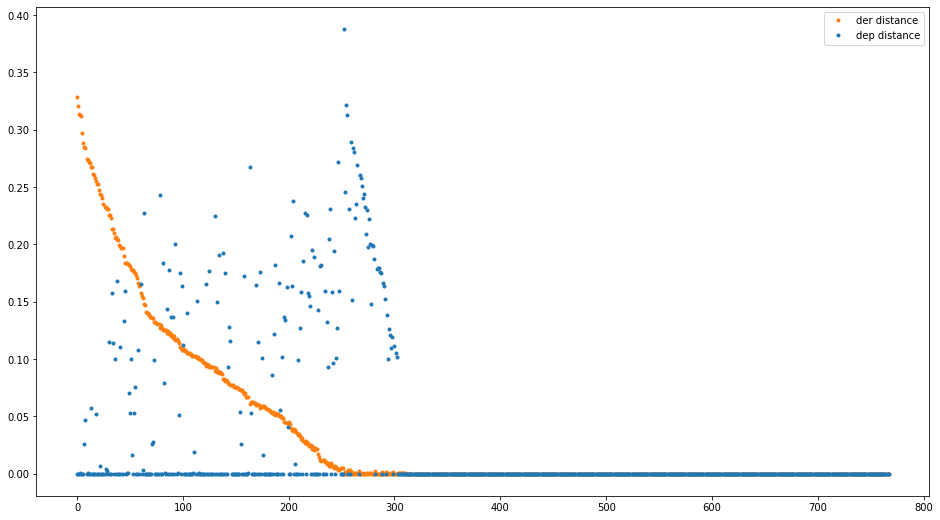

In [356]:
 layer_idx = 9

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance','der distance', 'dep distance'])

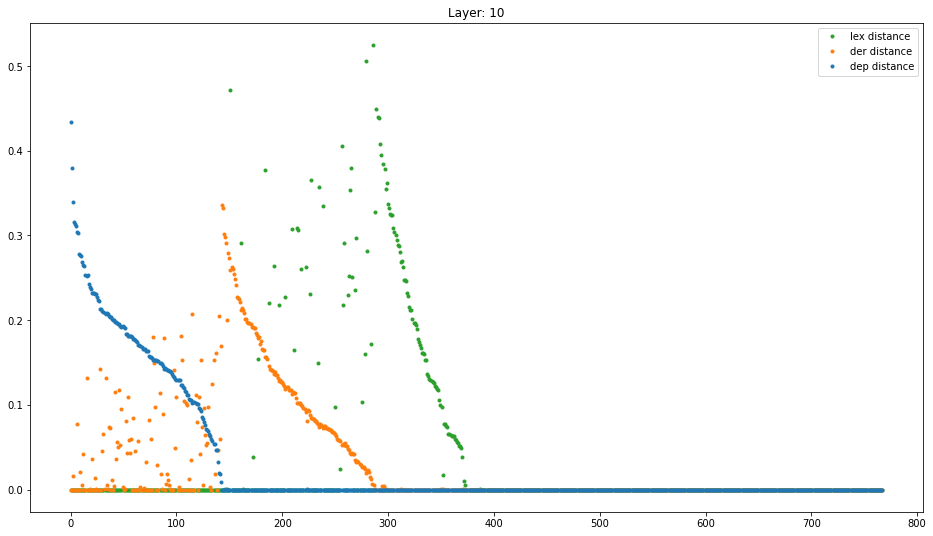

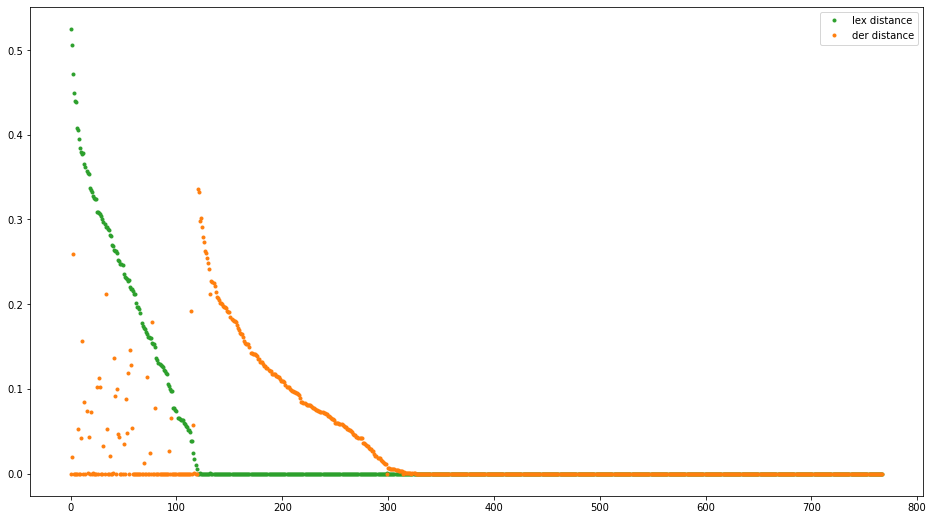

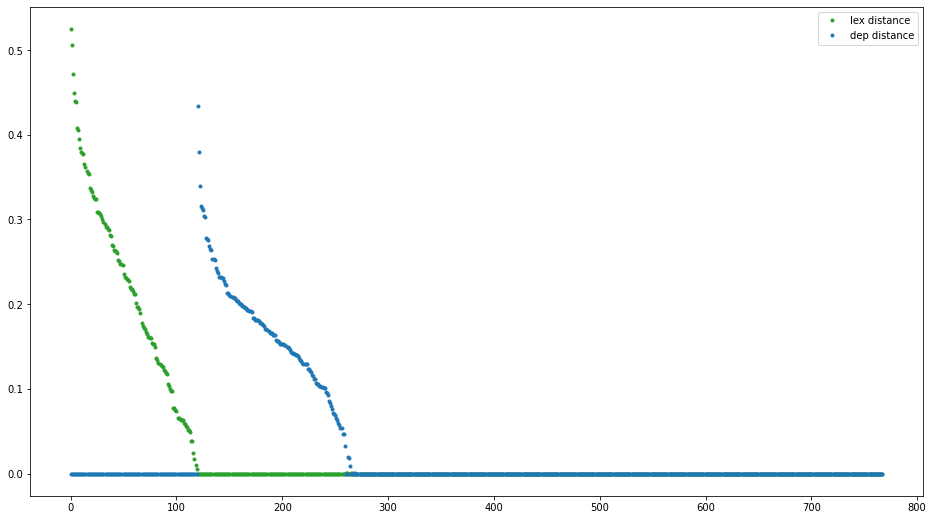

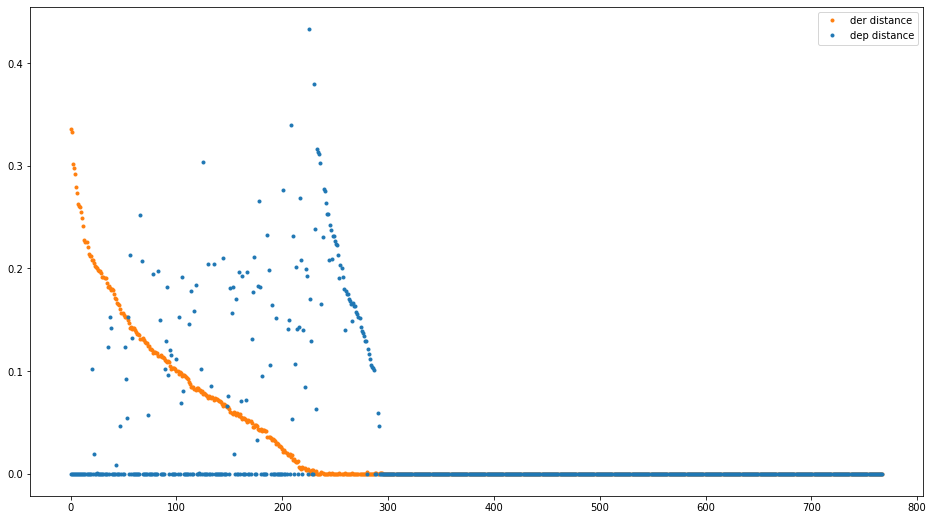

In [357]:
layer_idx = 10

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance','der distance', 'dep distance'])

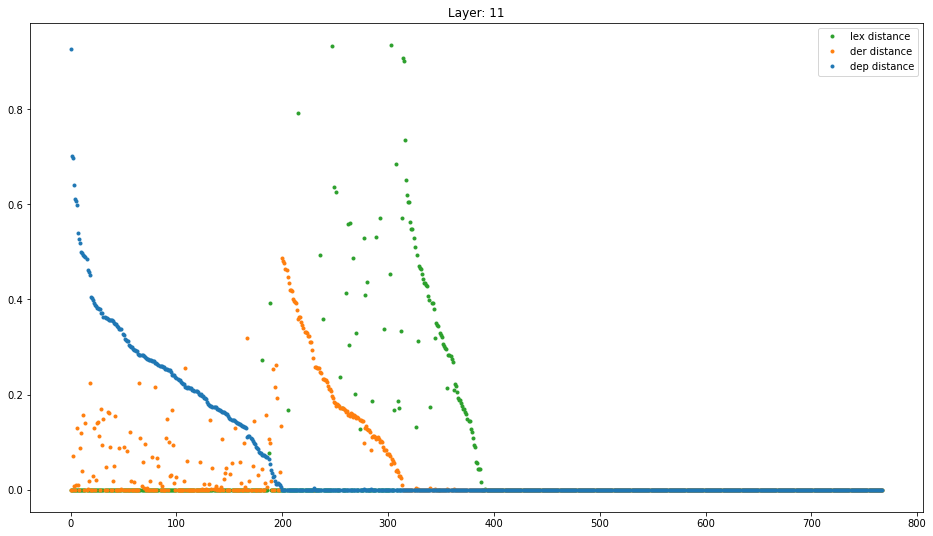

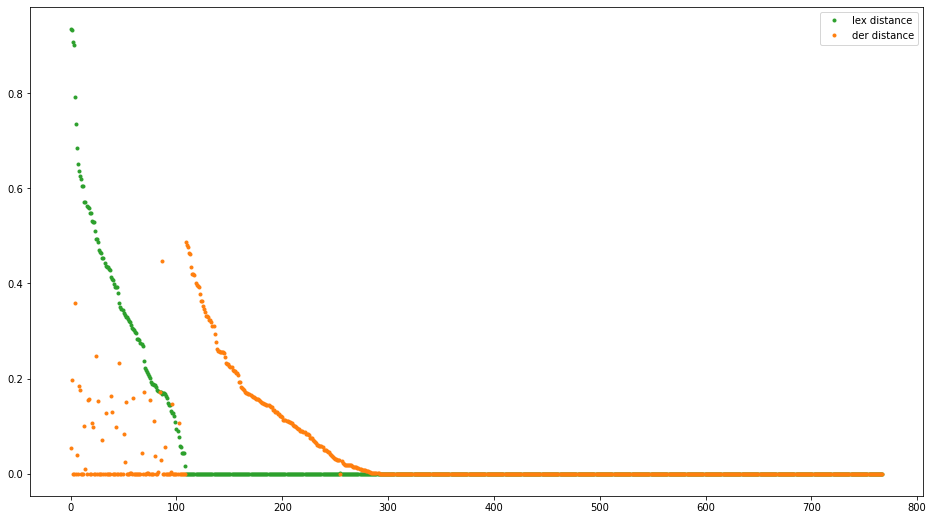

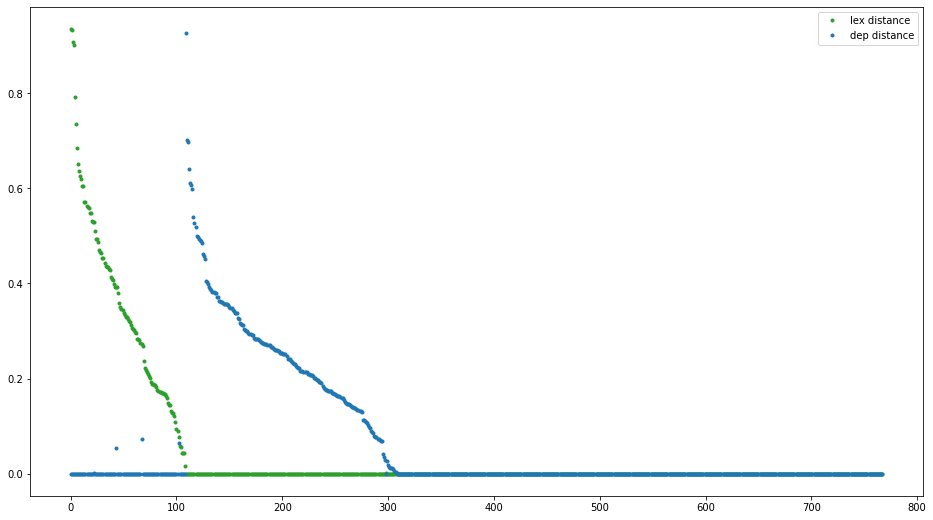

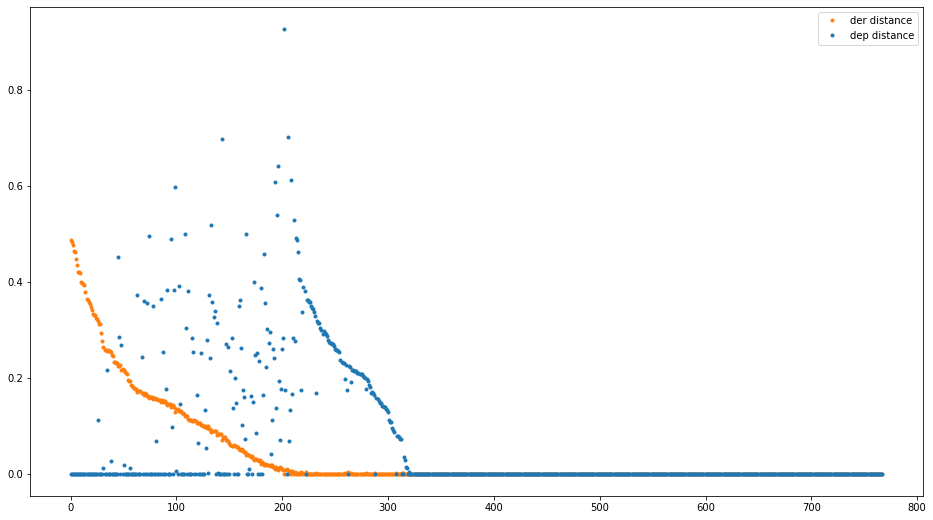

In [358]:
layer_idx = 11

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, der_distance_probe, dep_distance_probe], 
                              ['lex distance','der distance', 'dep distance'])

### Other orderings of tasks



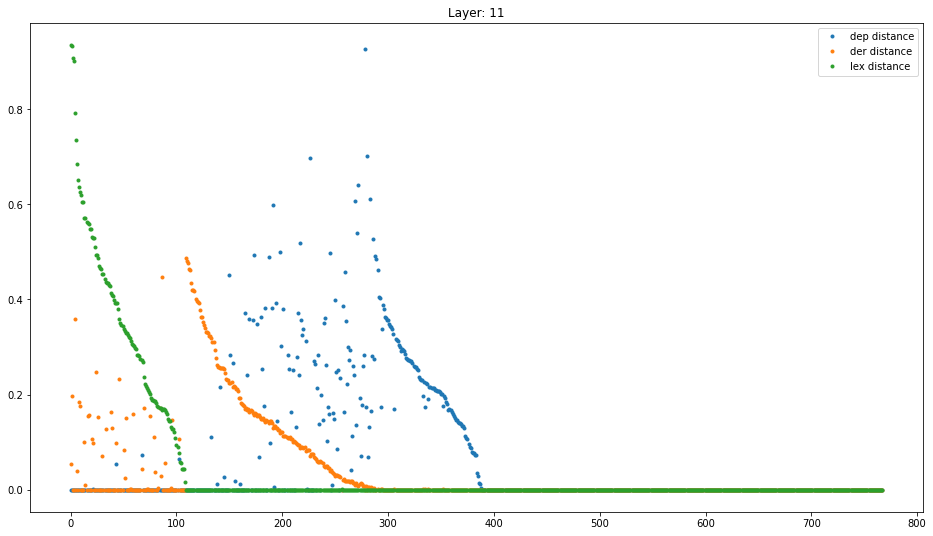

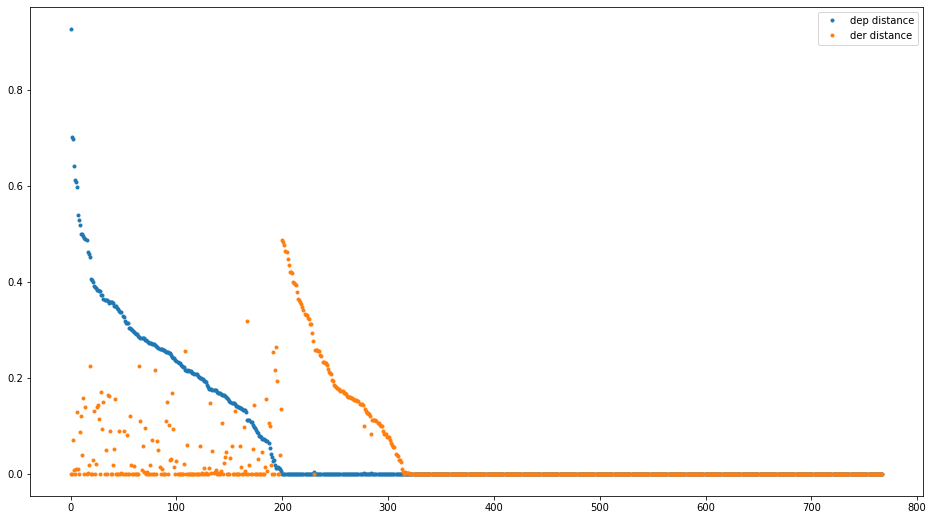

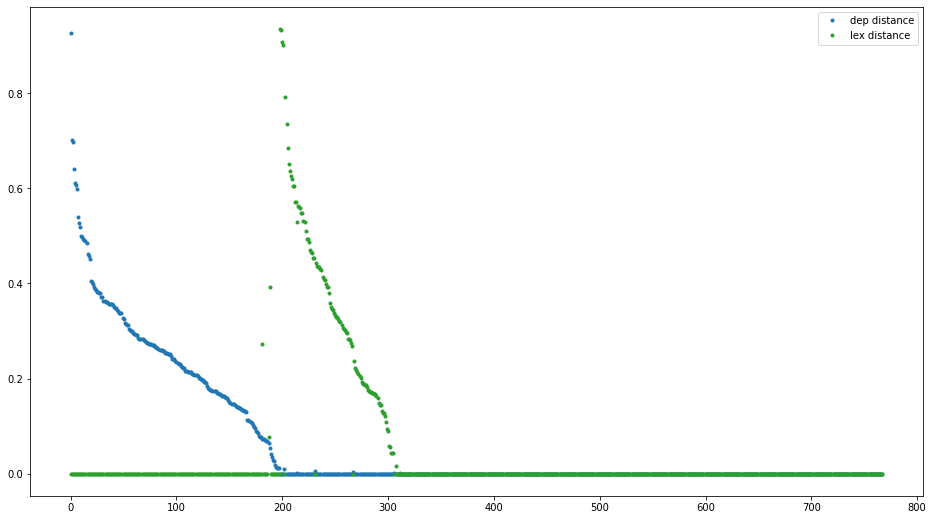

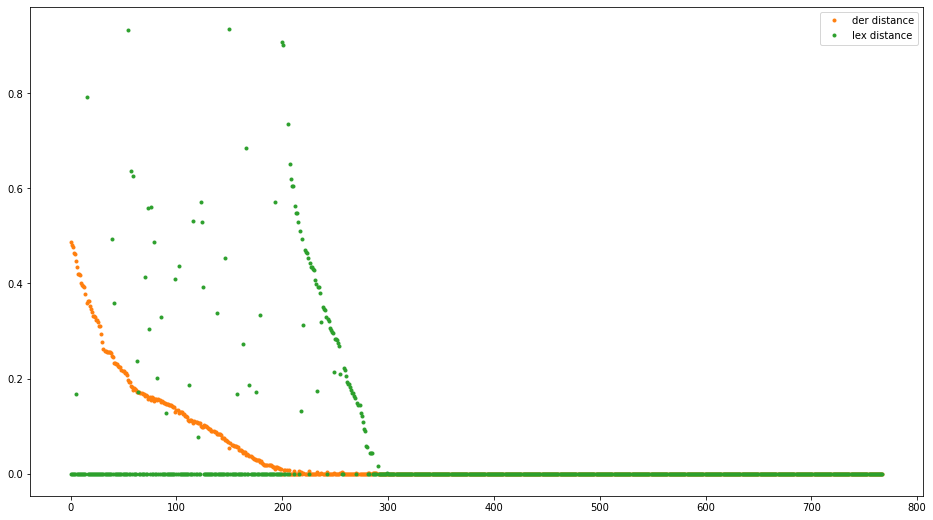

In [359]:
layer_idx = 11

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([dep_distance_probe, der_distance_probe, lex_distance_probe], 
                              ['dep distance', 'der distance', 'lex distance'])

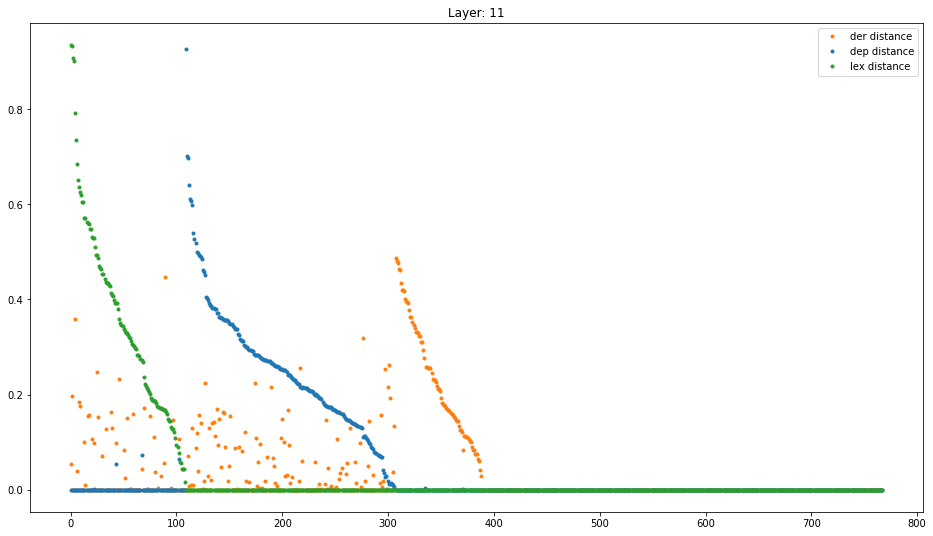

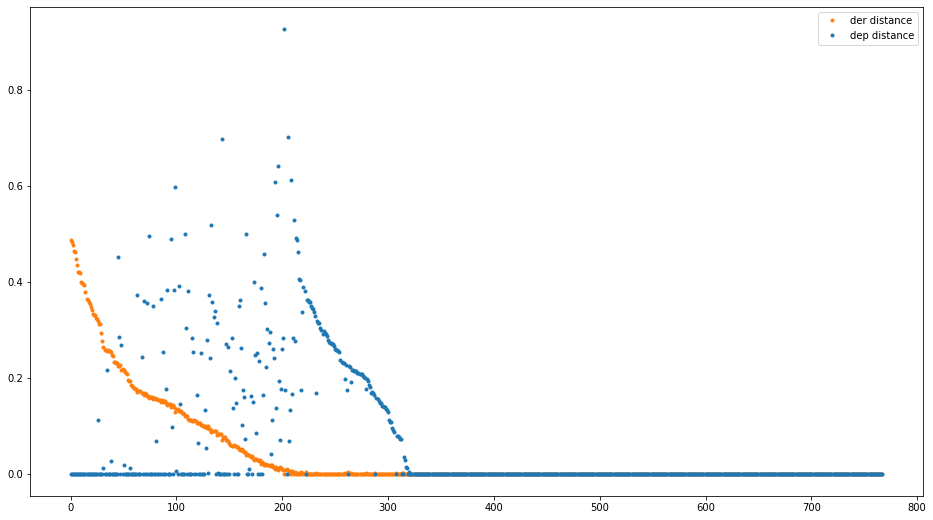

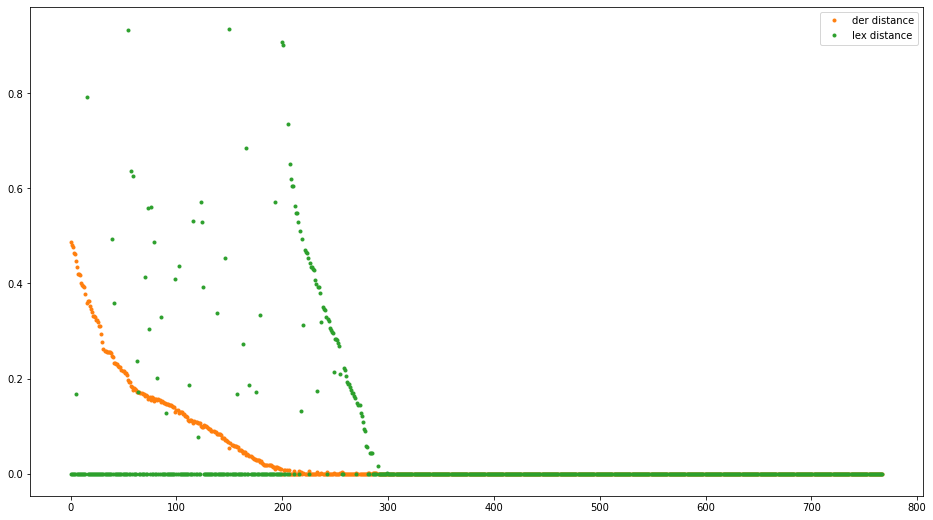

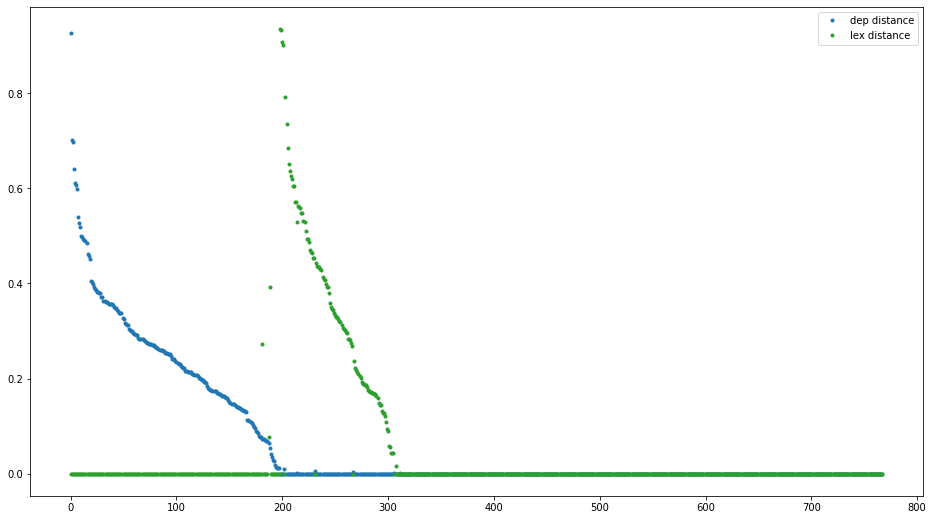

In [360]:
layer_idx = 11

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe, lex_distance_probe], 
                              ['der distance', 'dep distance', 'lex distance'])

## lex vs dep


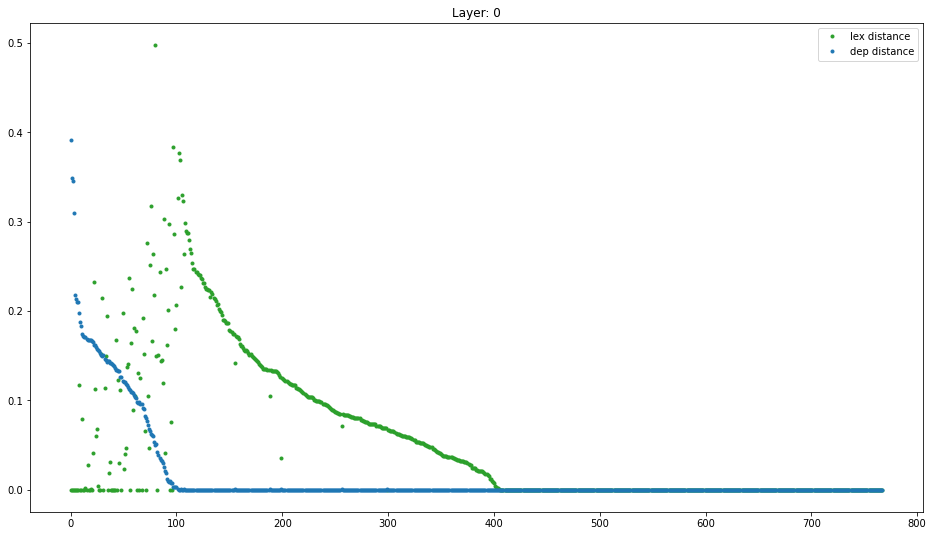

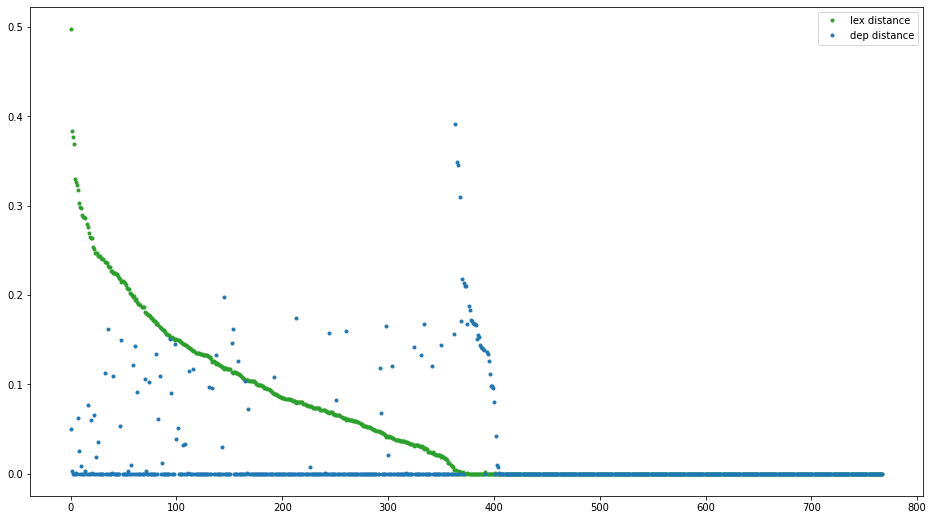

In [361]:
layer_idx = 0

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

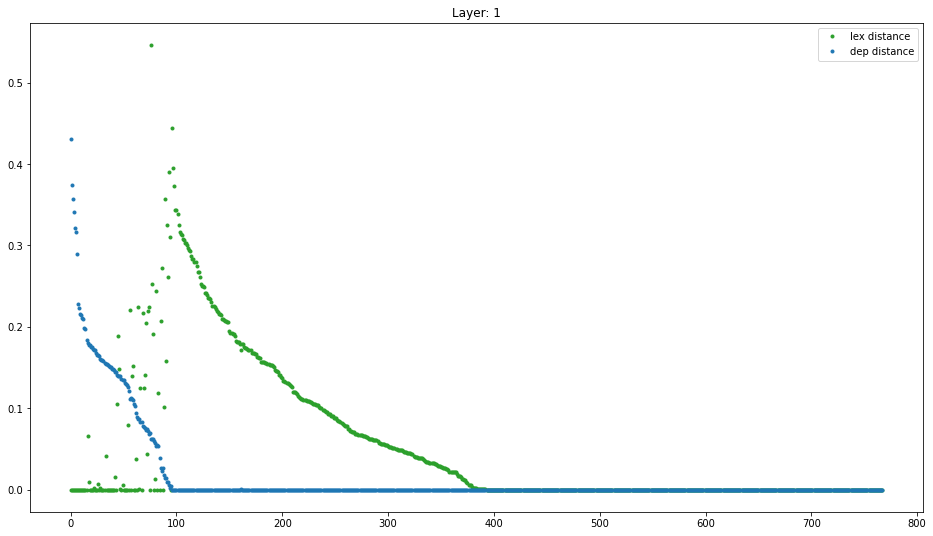

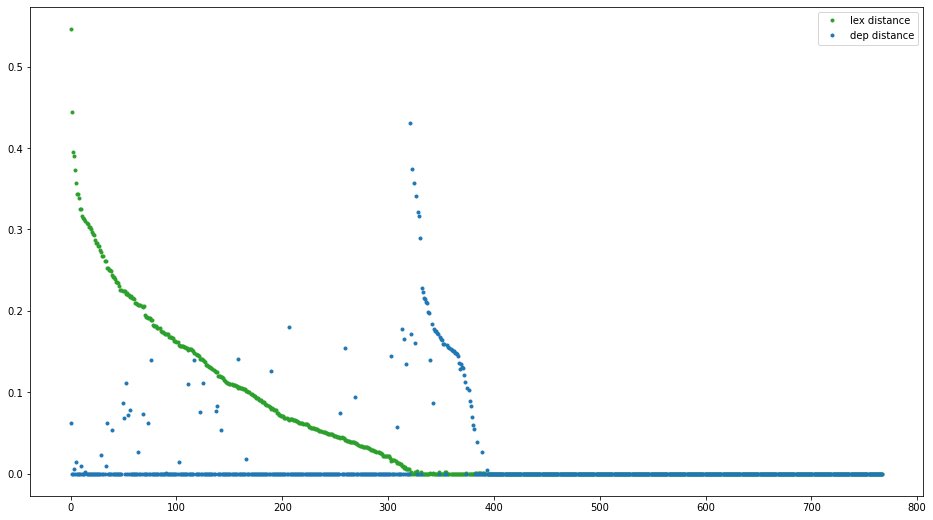

In [362]:
layer_idx = 1

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

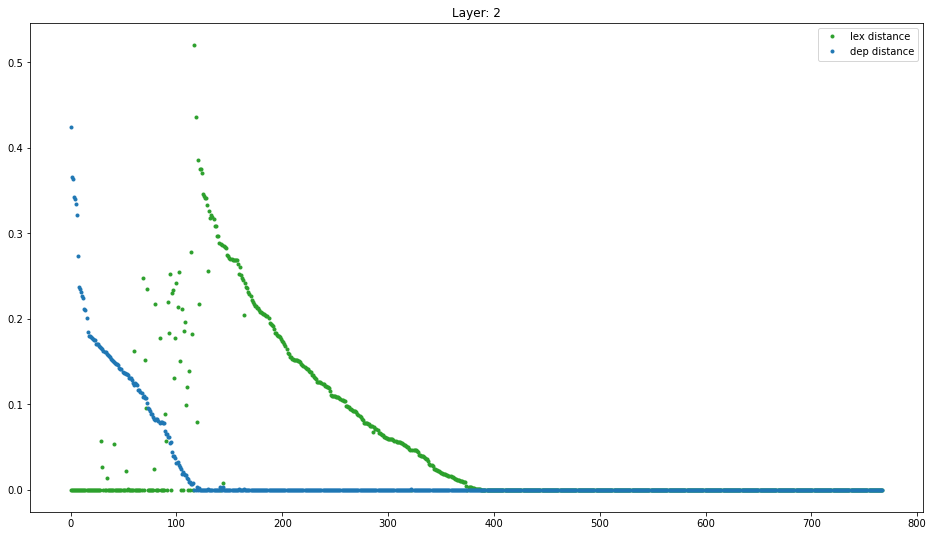

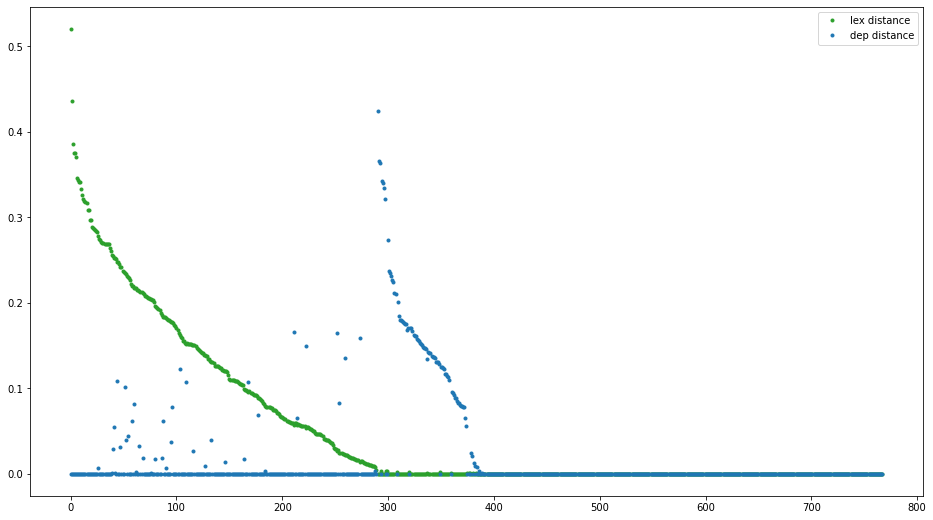

In [363]:
layer_idx = 2

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

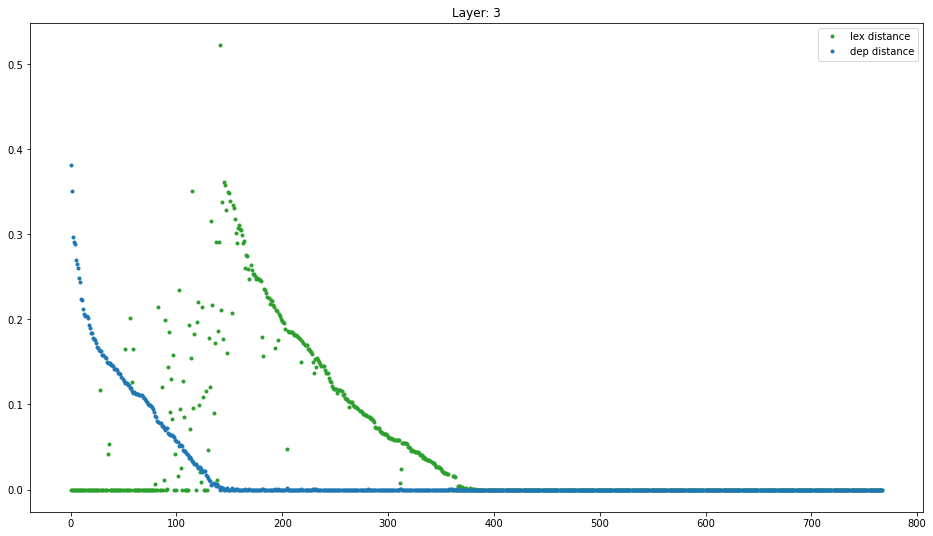

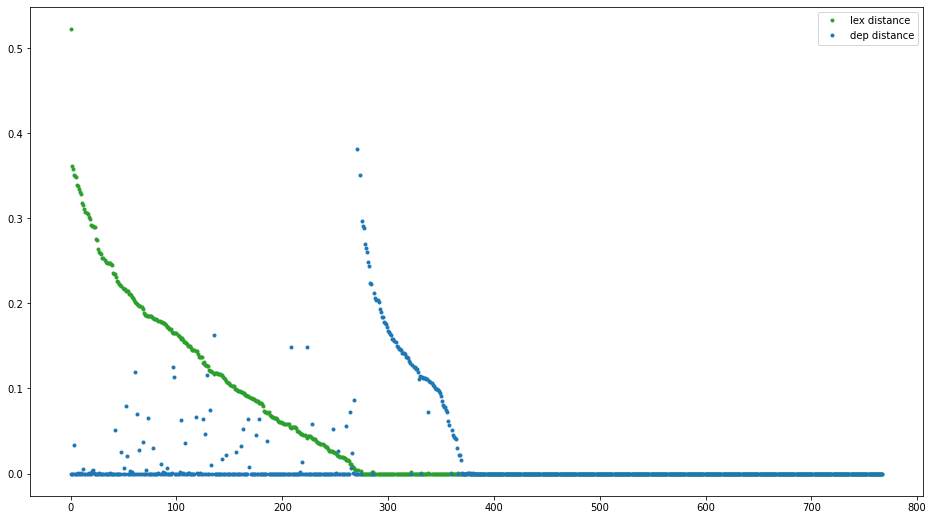

In [364]:
layer_idx = 3

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

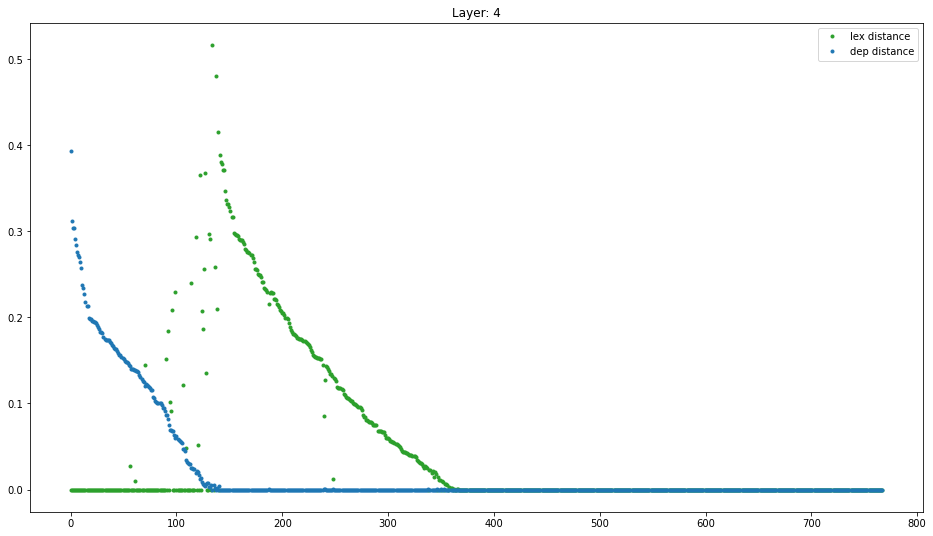

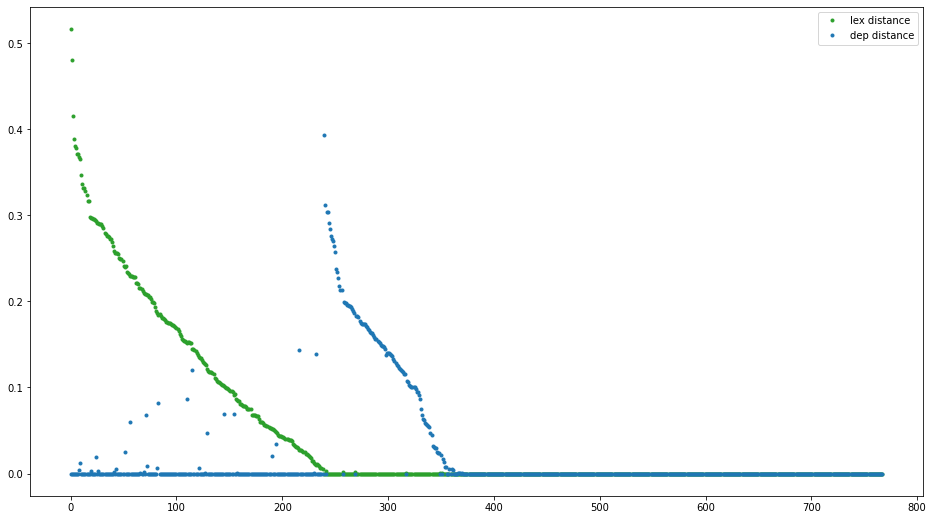

In [365]:
layer_idx = 4

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

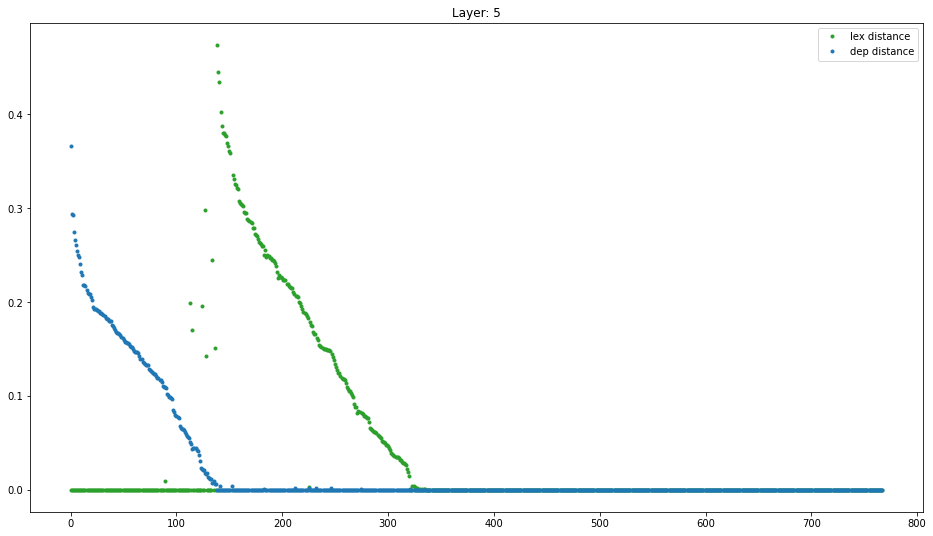

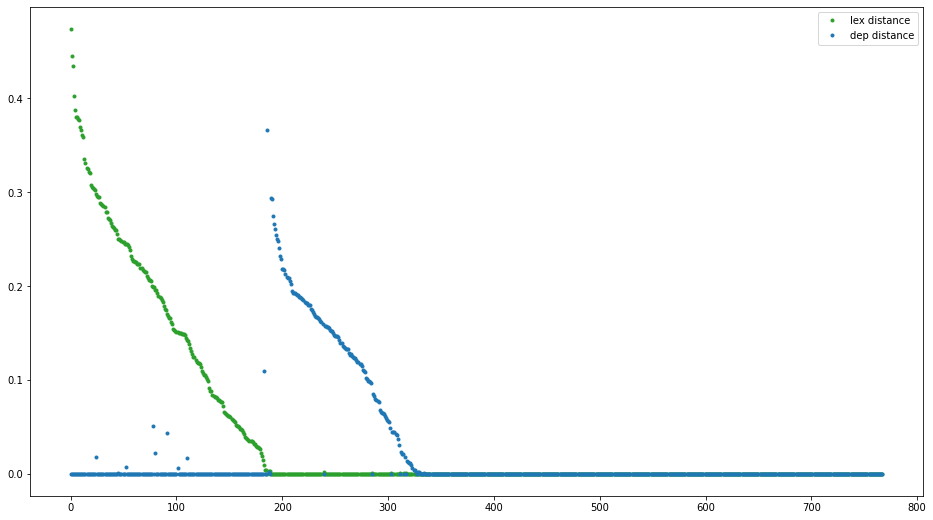

In [366]:
layer_idx = 5

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

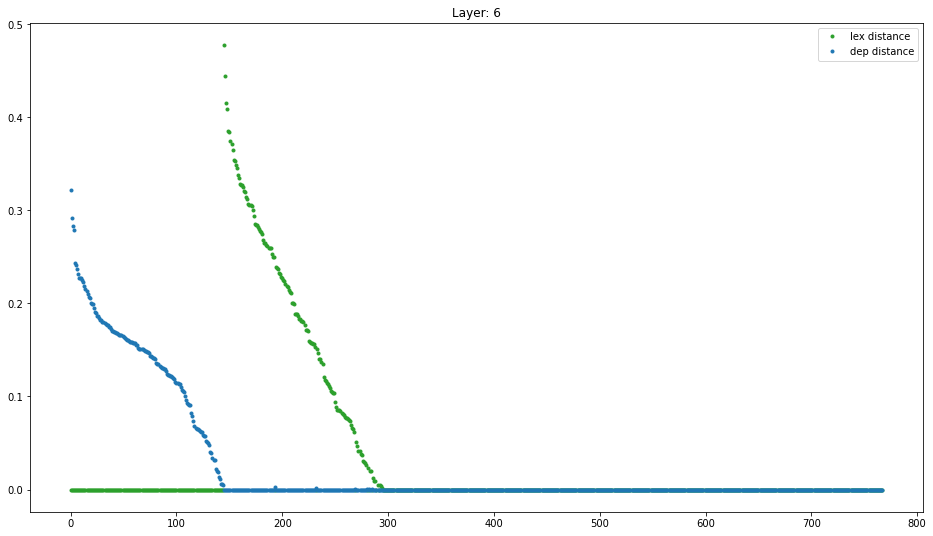

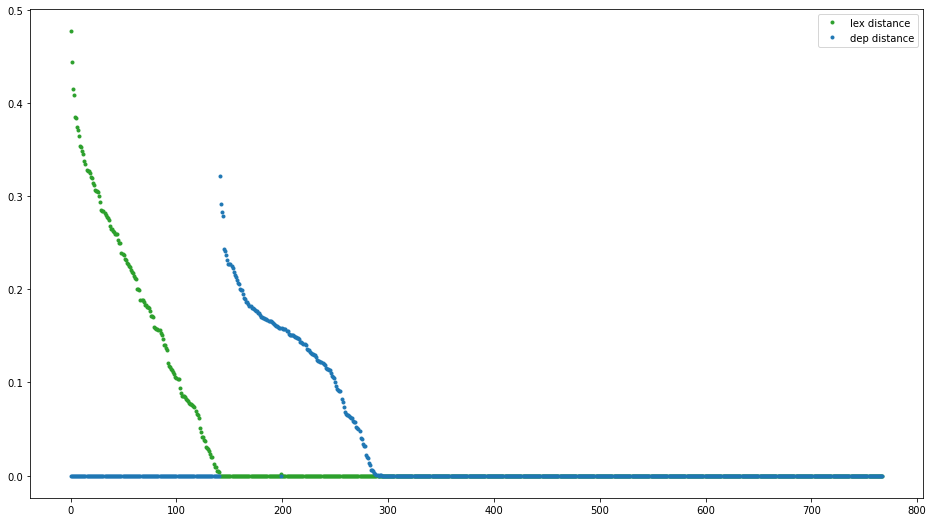

In [367]:
layer_idx = 6

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()
    
visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

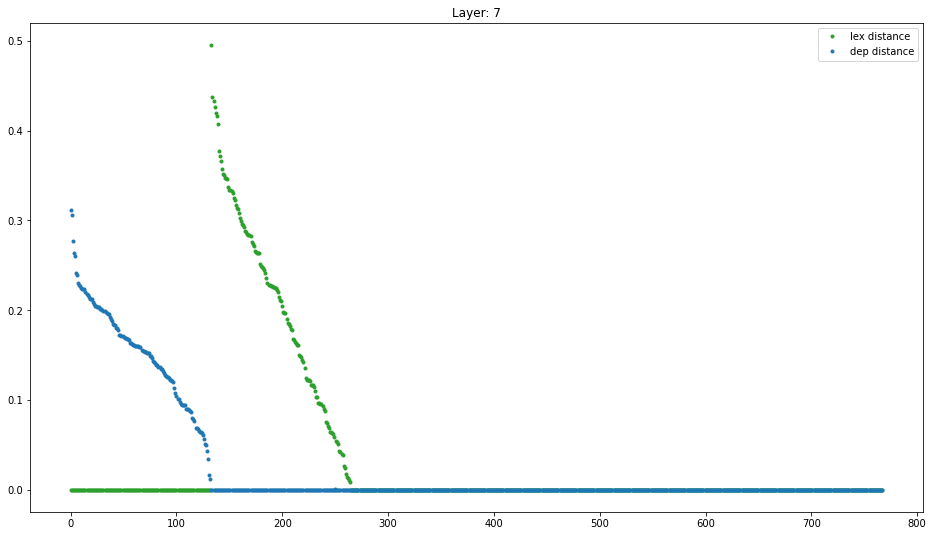

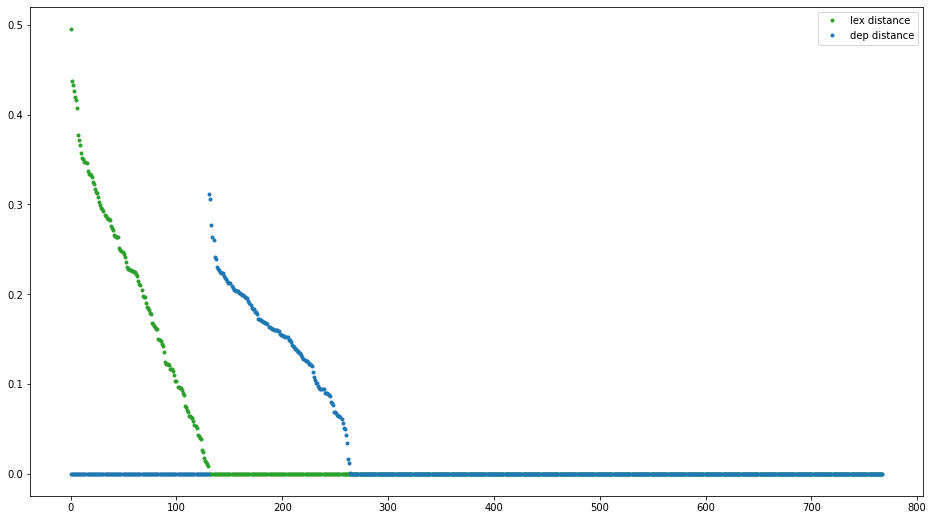

In [368]:
layer_idx = 7

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

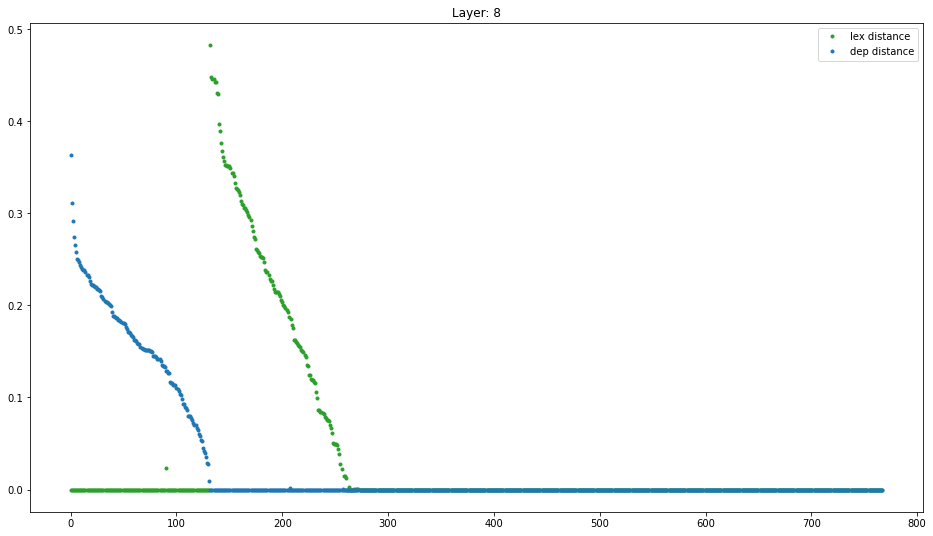

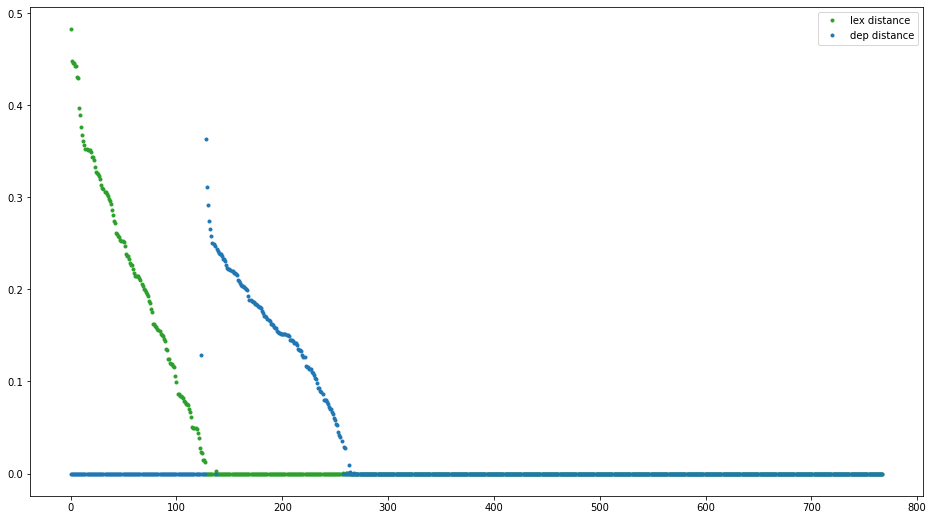

In [369]:
layer_idx = 8

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

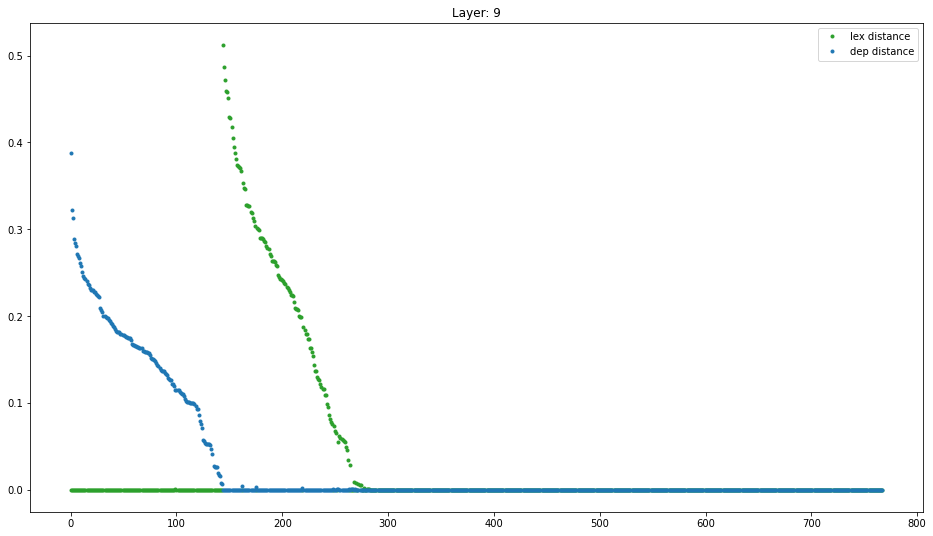

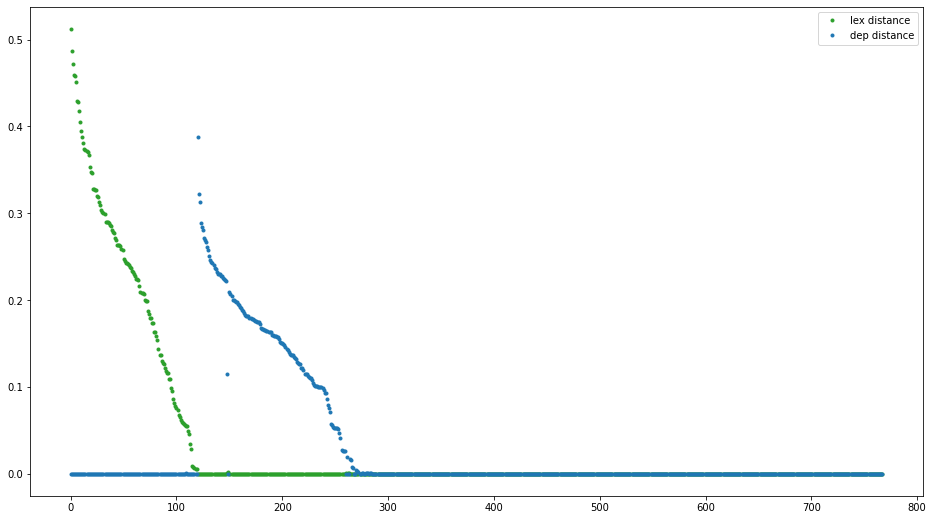

In [370]:
layer_idx = 9

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

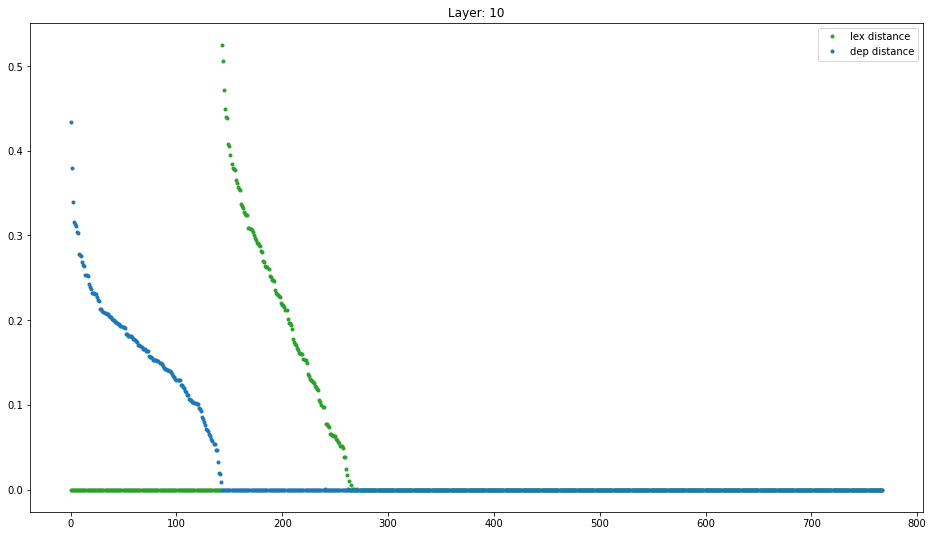

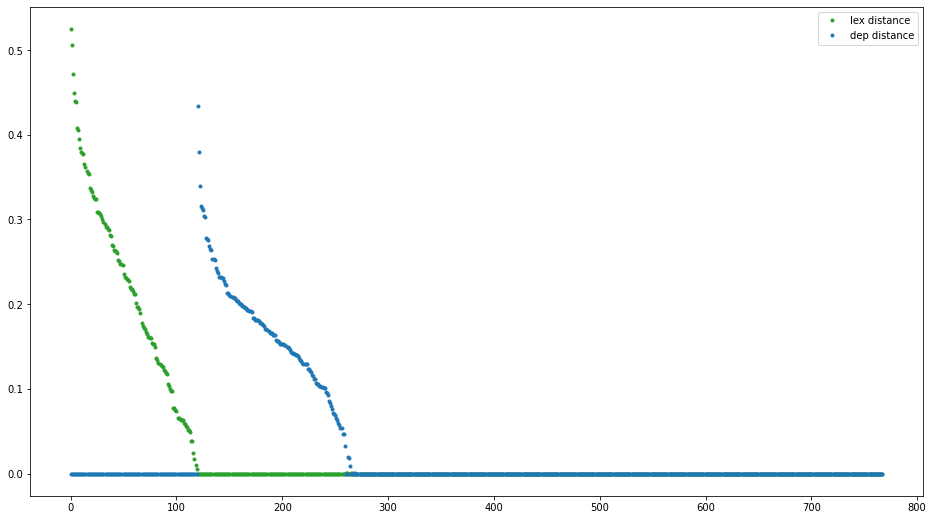

In [371]:
layer_idx = 10

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

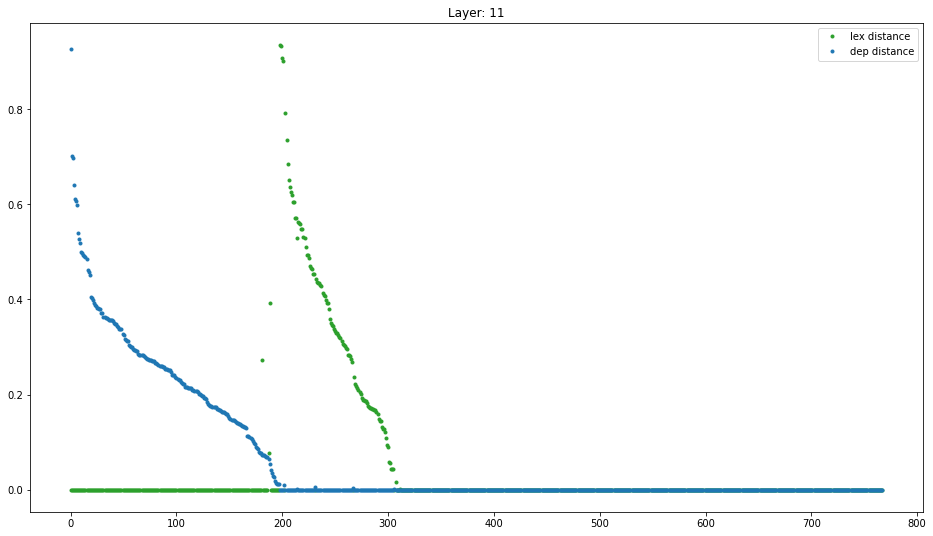

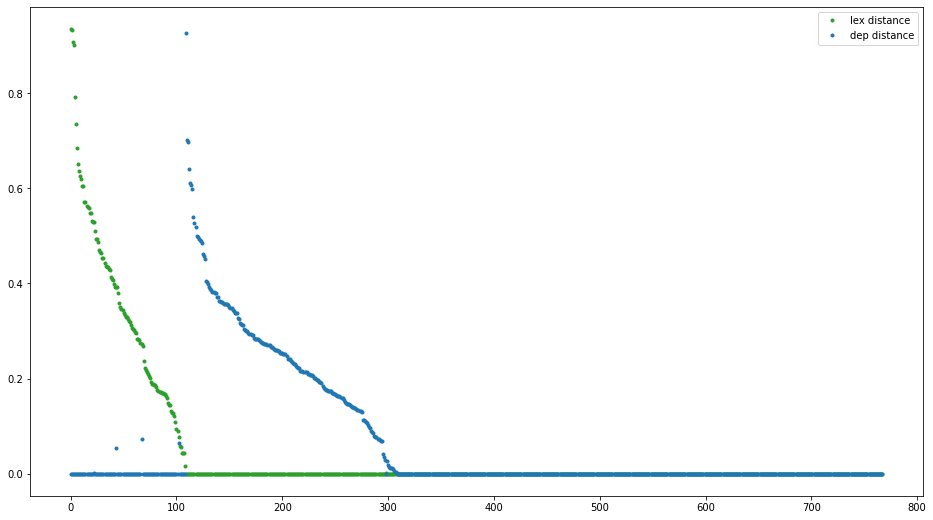

In [372]:
layer_idx = 11

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe], 
                              ['lex distance', 'dep distance'])

### dep vs der


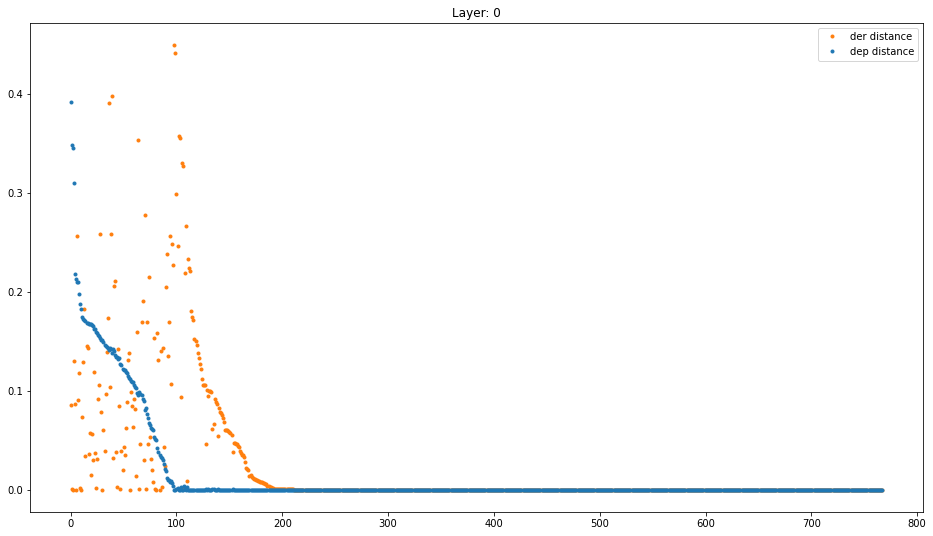

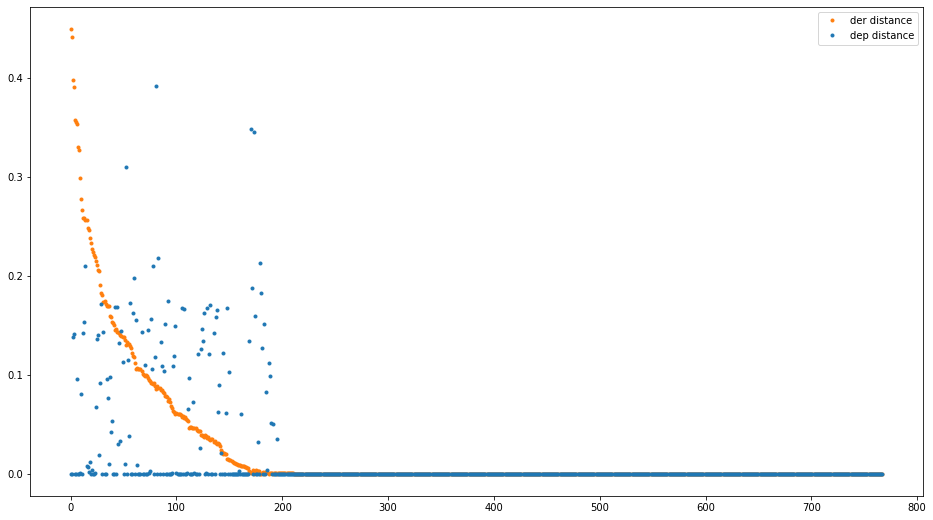

In [373]:
layer_idx = 0

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

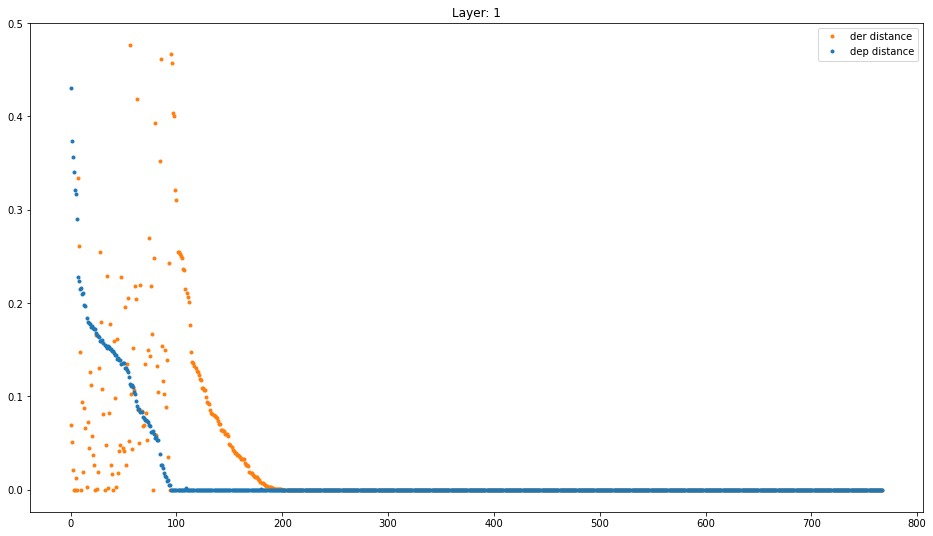

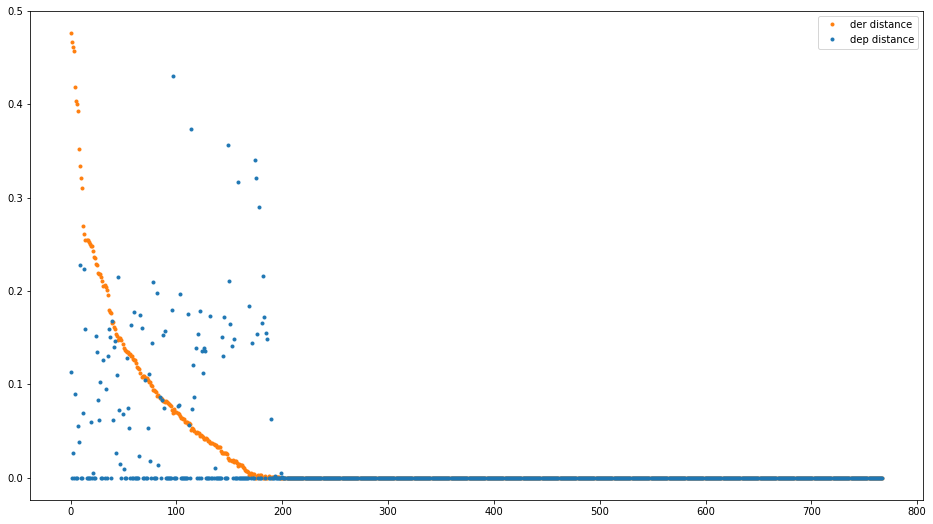

In [374]:
layer_idx = 1

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

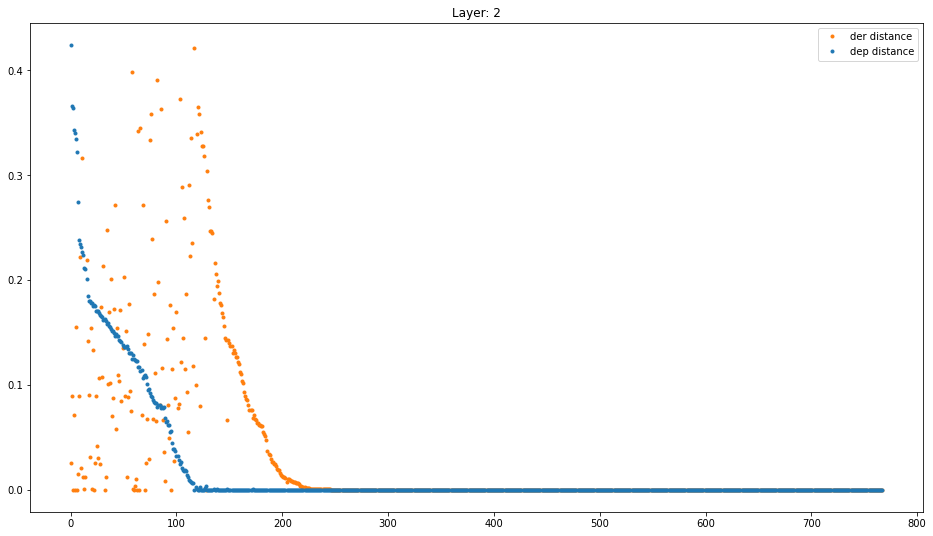

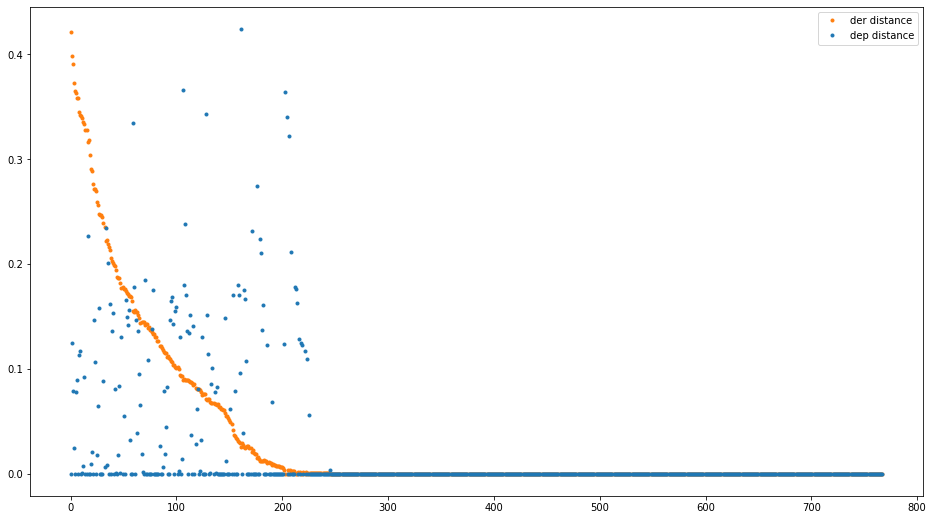

In [375]:
layer_idx = 2

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

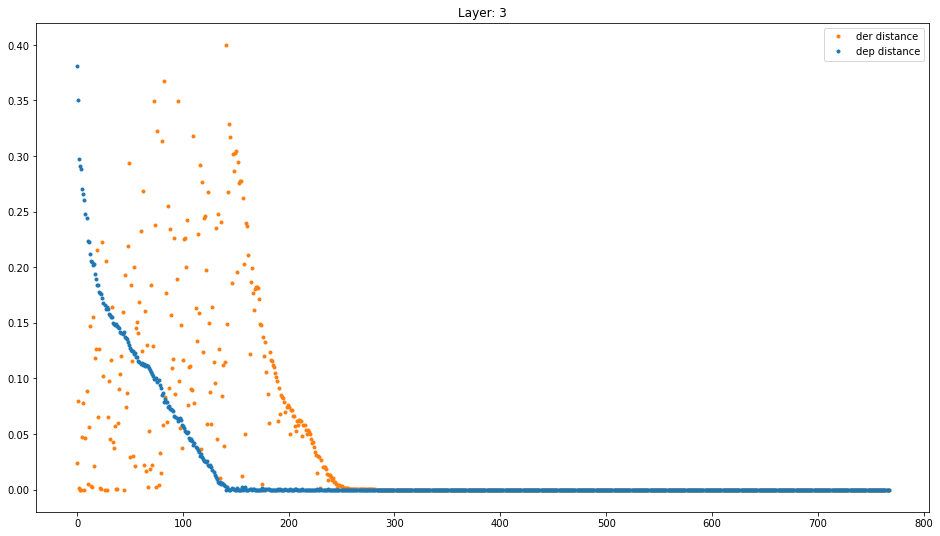

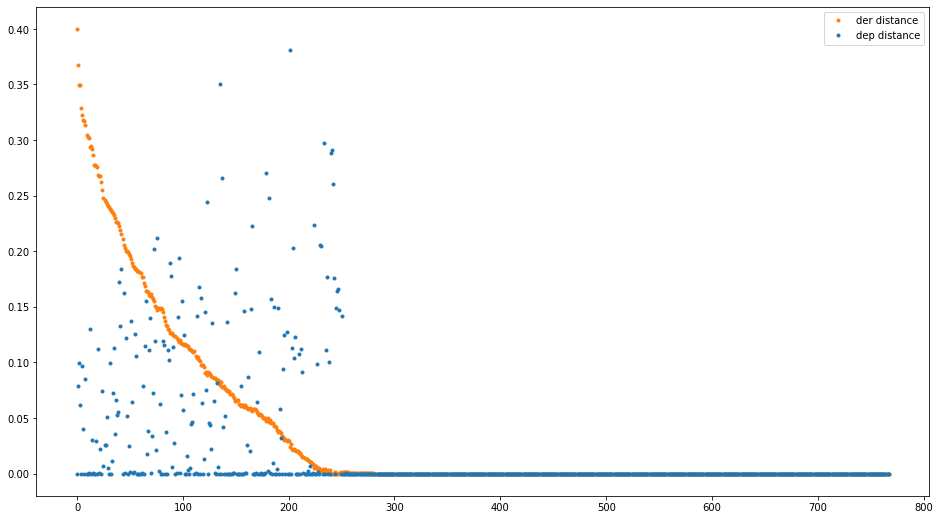

In [376]:
layer_idx = 3

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

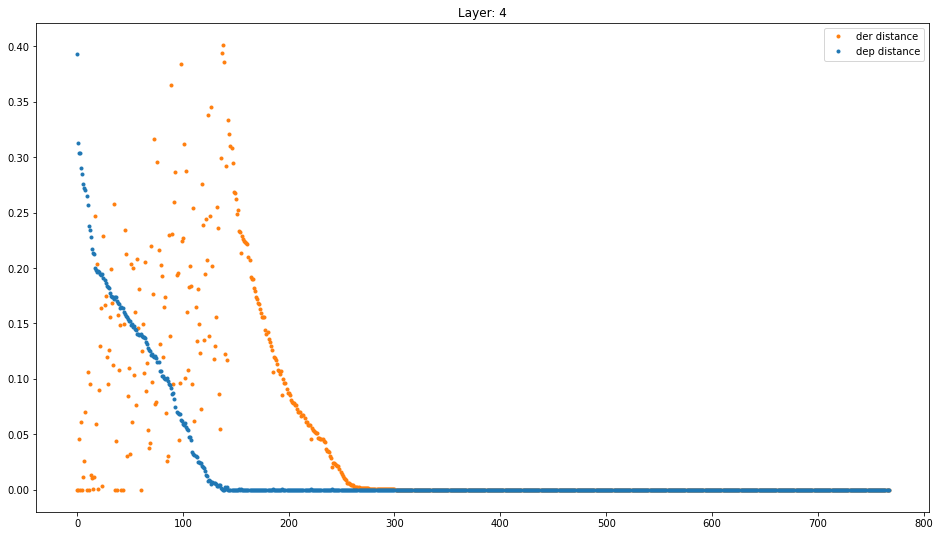

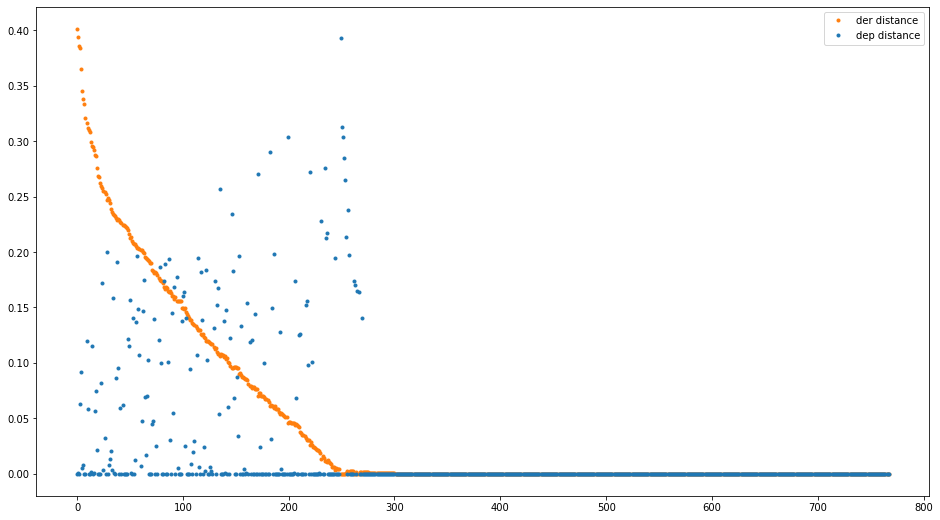

In [377]:
layer_idx = 4

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

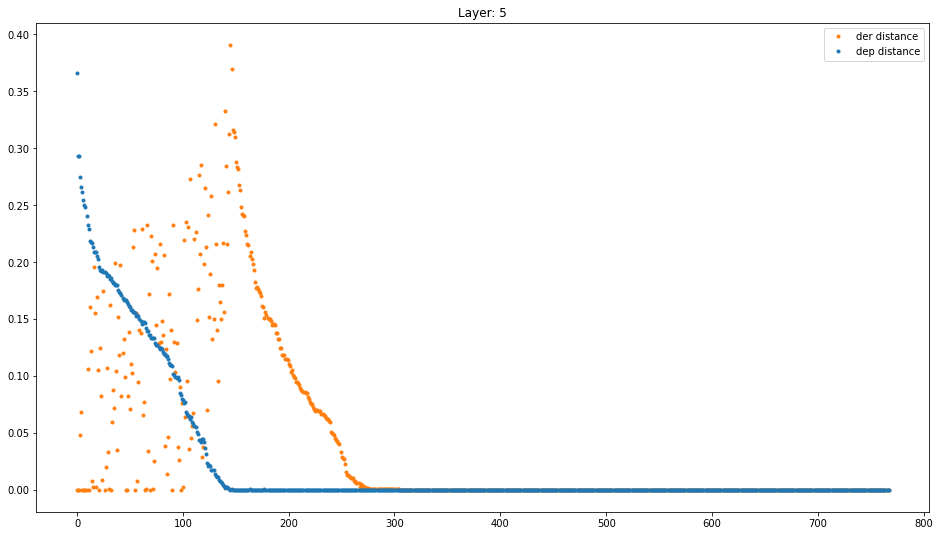

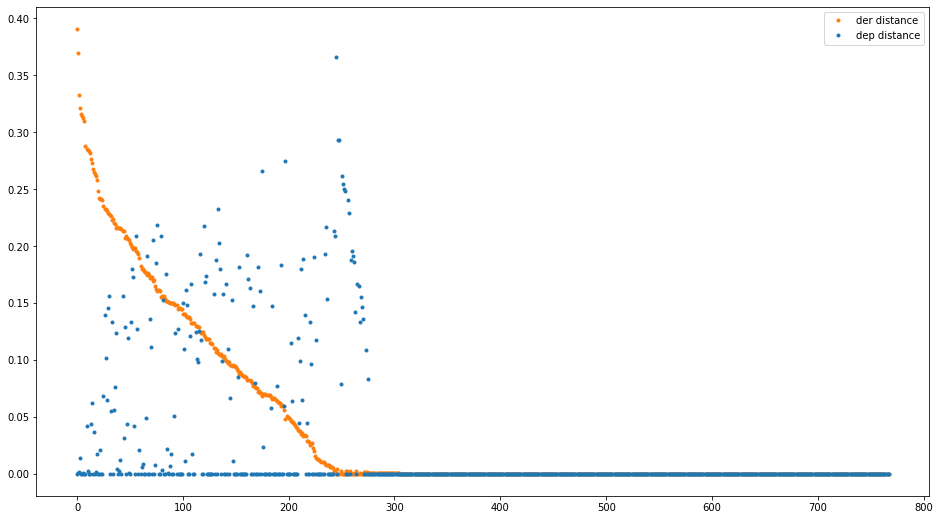

In [378]:
layer_idx = 5

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

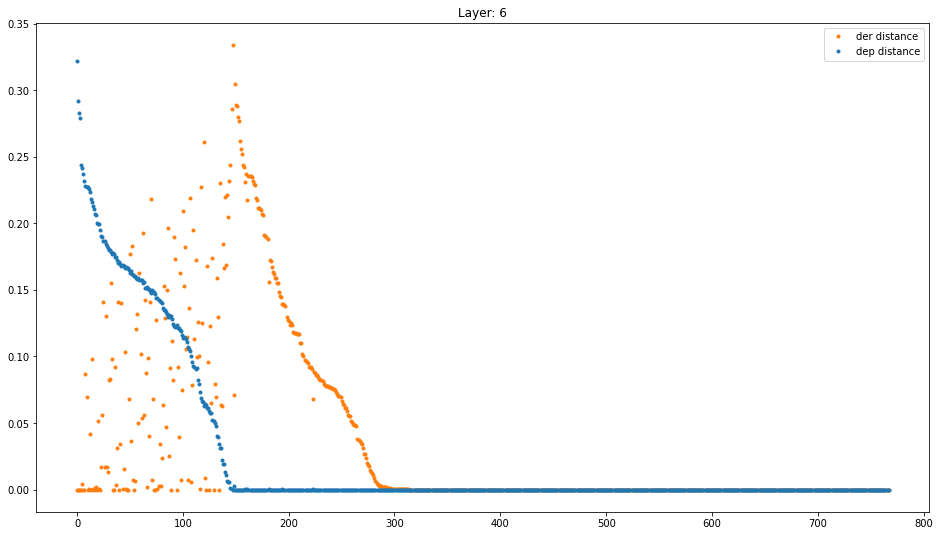

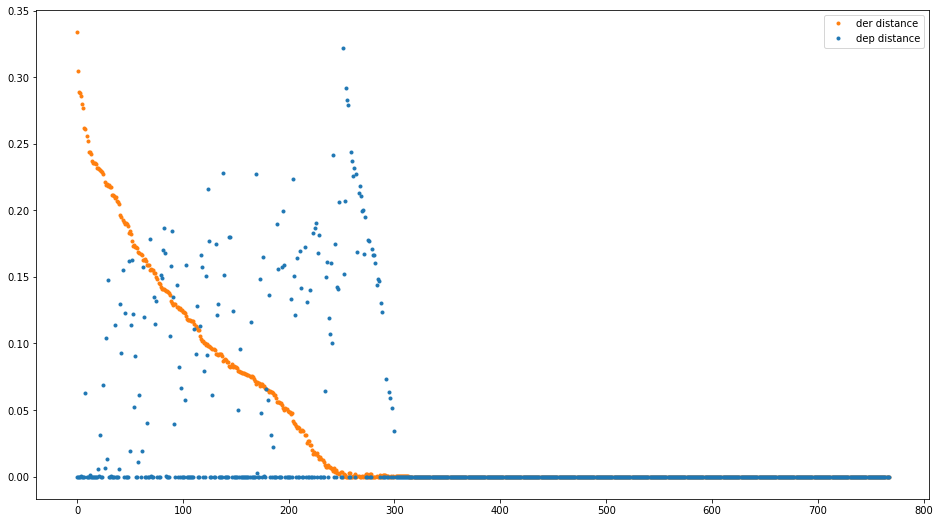

In [379]:
layer_idx = 6

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

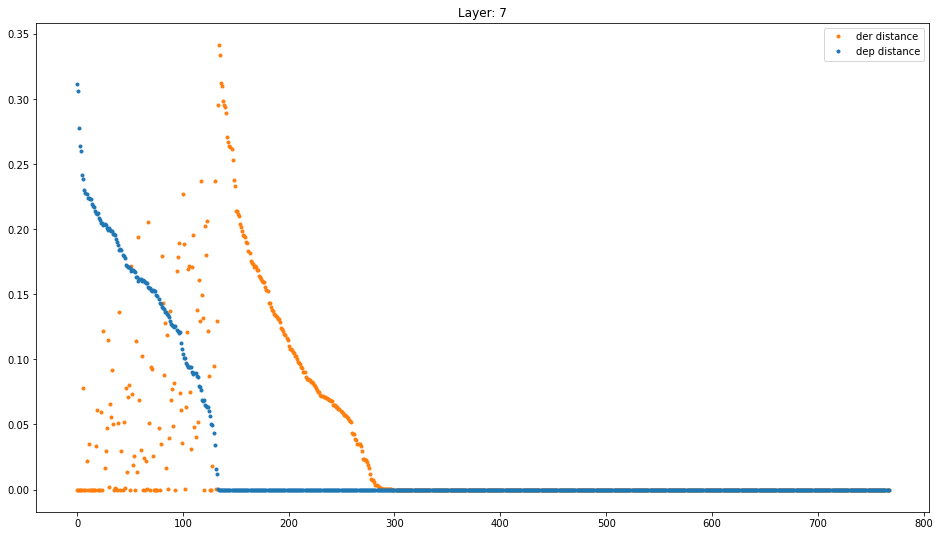

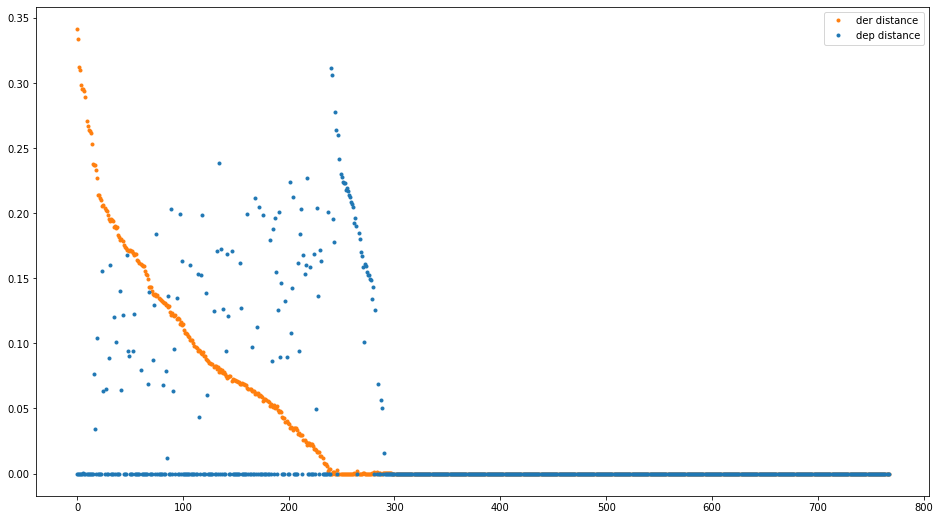

In [380]:
layer_idx = 7

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

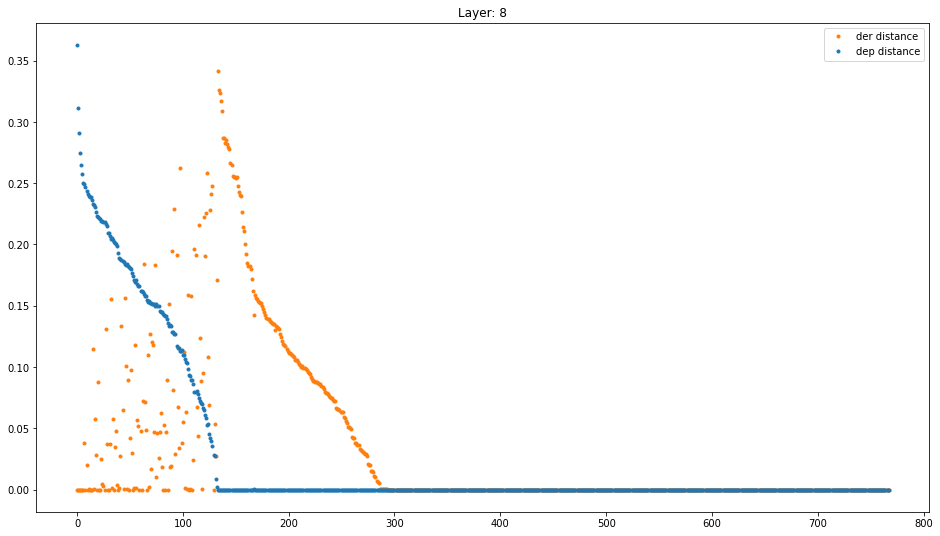

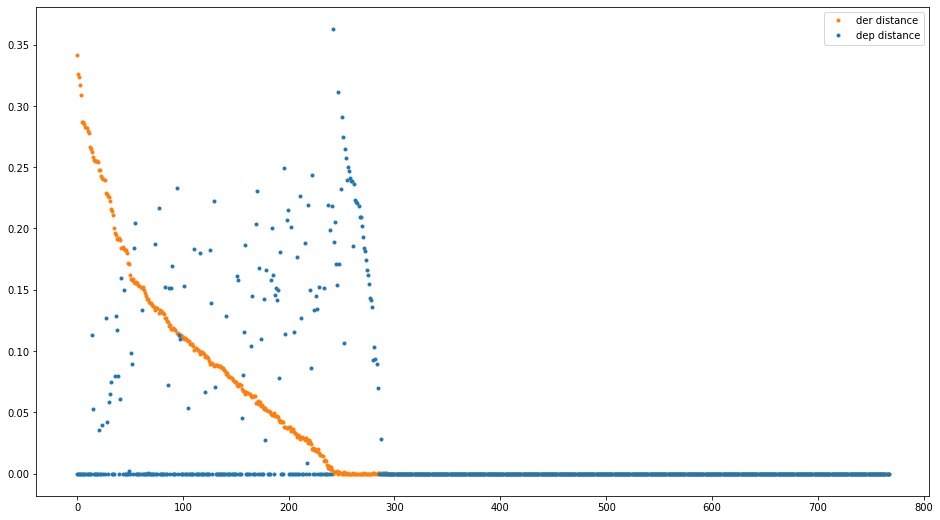

In [381]:
layer_idx = 8

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

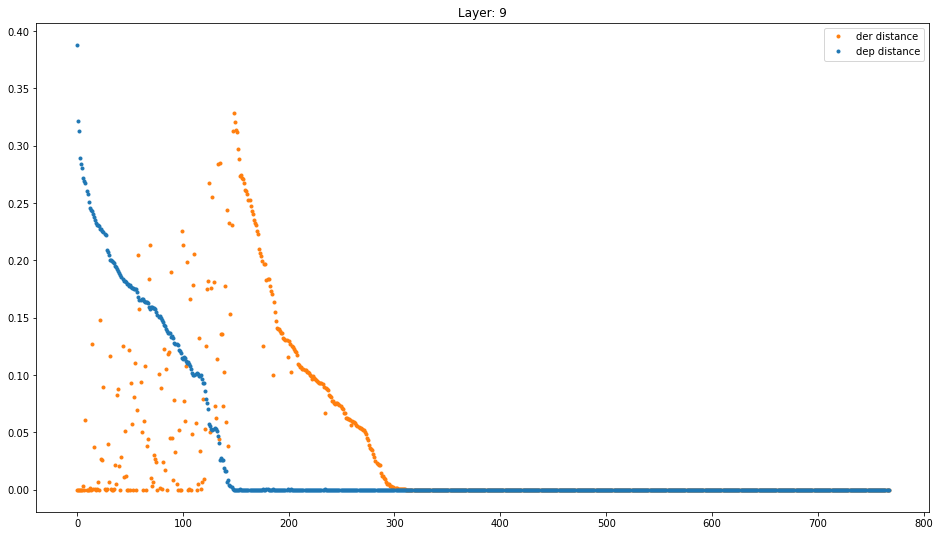

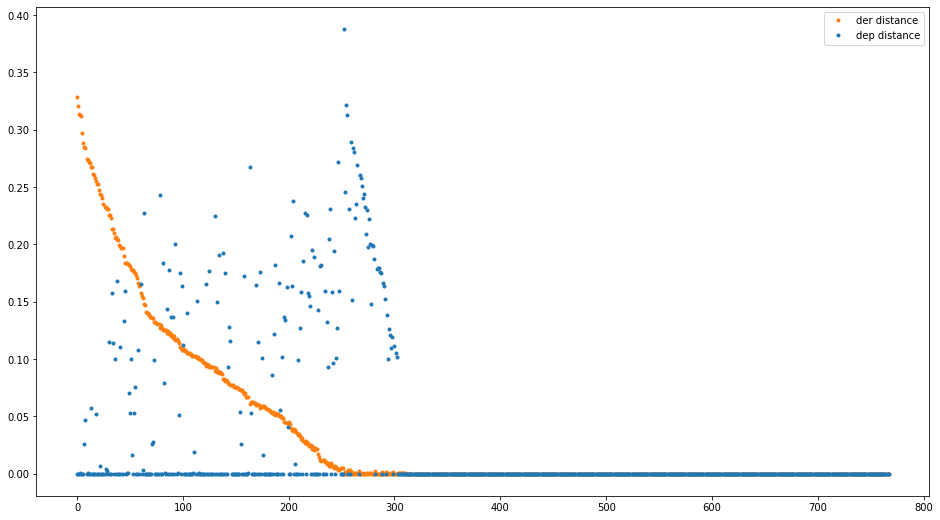

In [382]:
layer_idx = 9

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

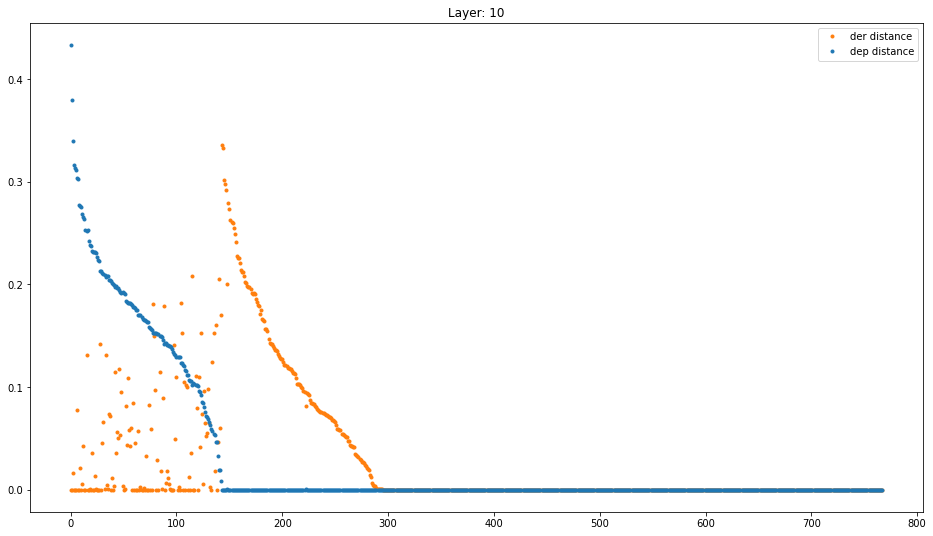

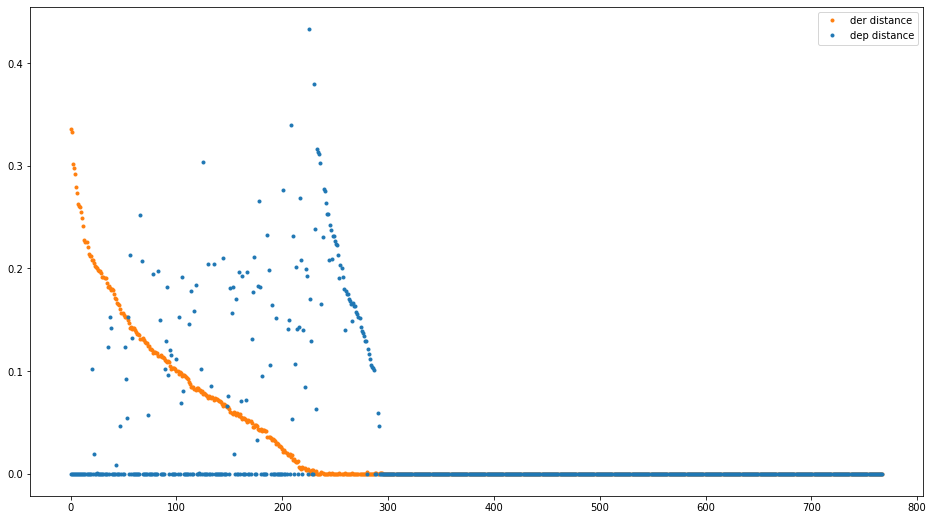

In [383]:
layer_idx = 10

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

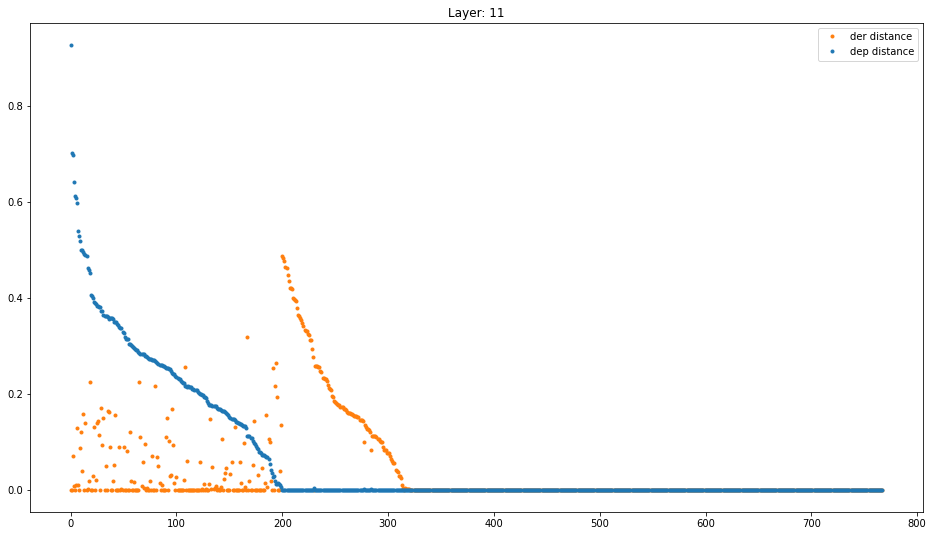

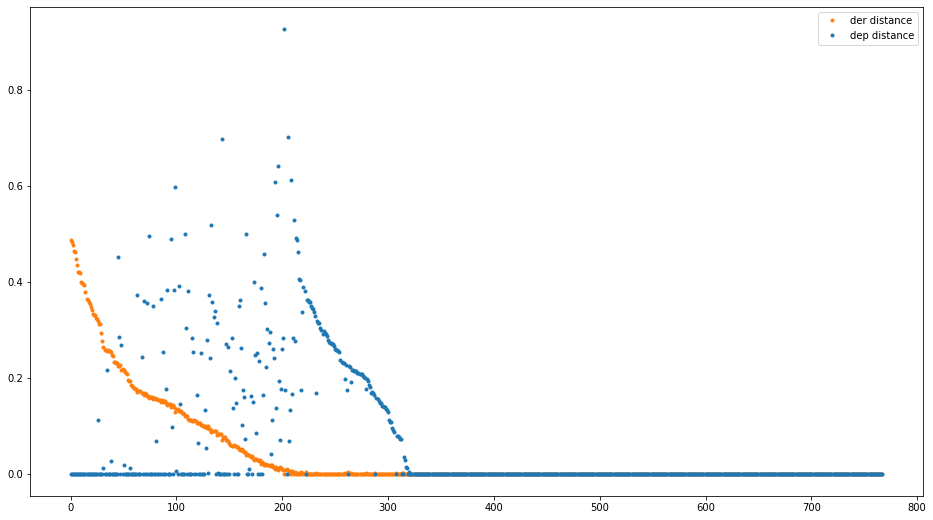

In [384]:
layer_idx = 11

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()

visualize_disentanglement([der_distance_probe, dep_distance_probe], 
                              ['der distance', 'dep distance'])

# Depth Distance zusamen

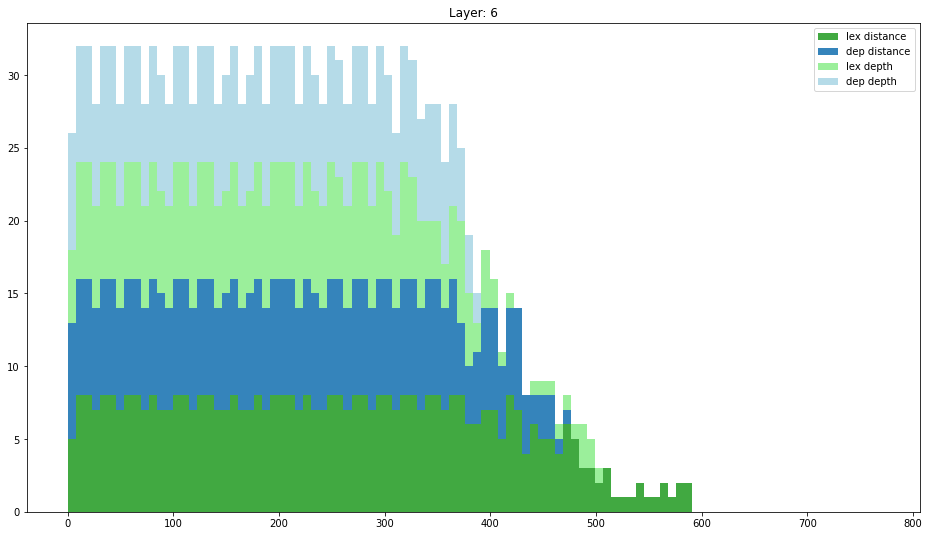

In [17]:
layer_idx = 6

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()
dep_depth_probe = ckpt.dep_depth.numpy().ravel()
lex_depth_probe = ckpt.lex_depth.numpy().ravel()
der_depth_probe = ckpt.der_depth.numpy().ravel()

visualize_histogram([lex_distance_probe, dep_distance_probe, lex_depth_probe, dep_depth_probe], 
                              ['lex distance','dep distance', 'lex depth', 'dep depth'])

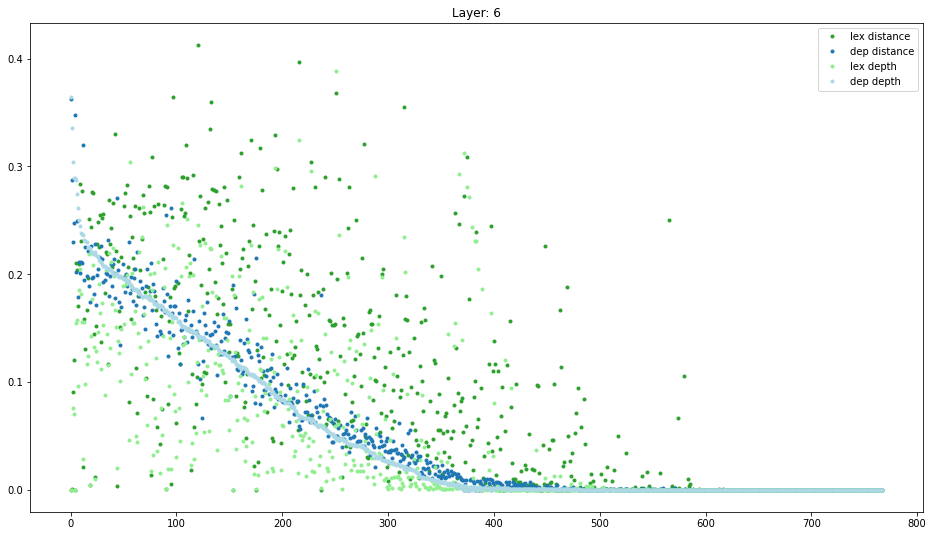

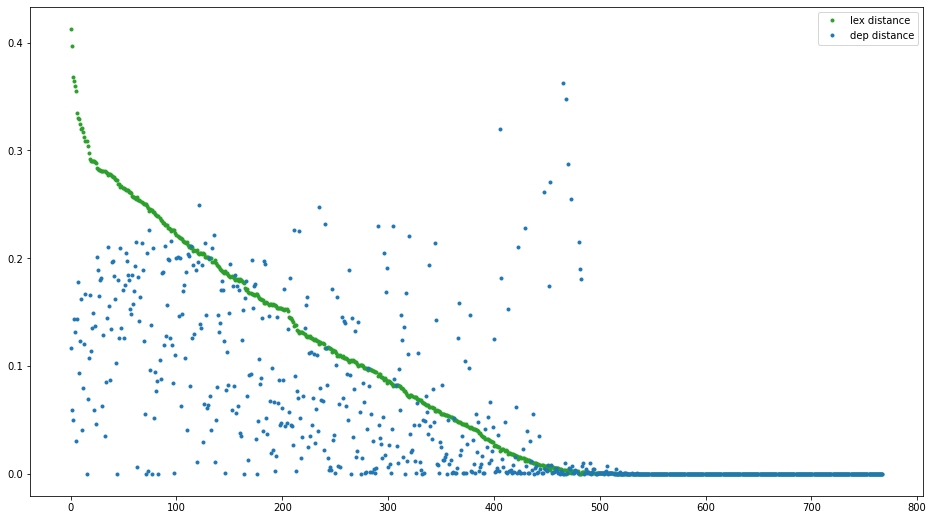

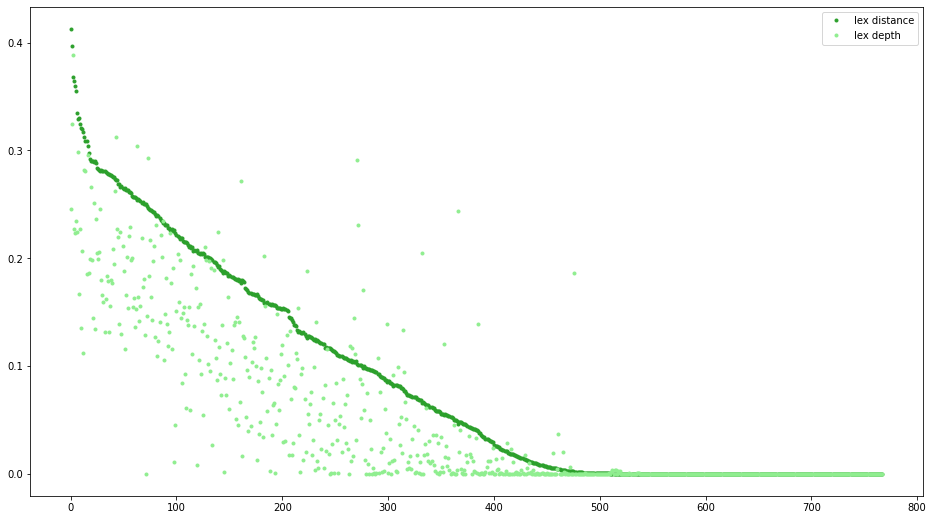

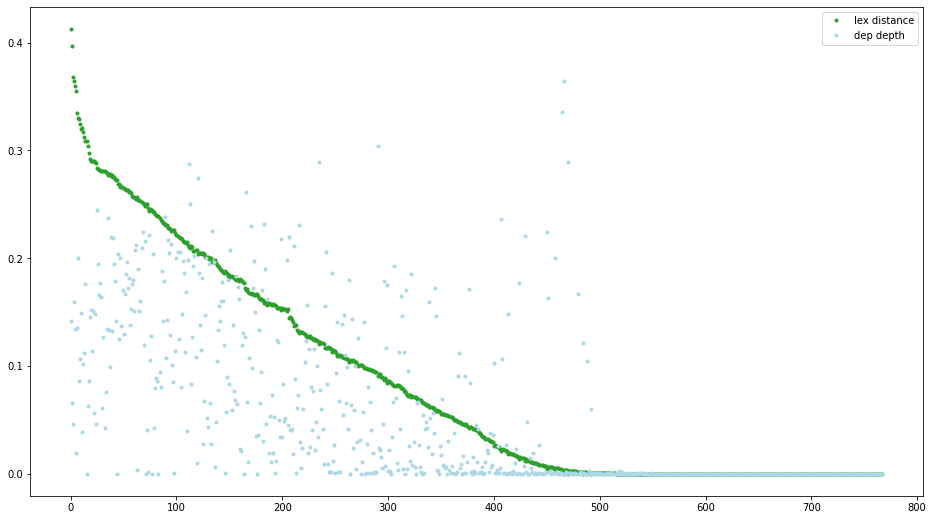

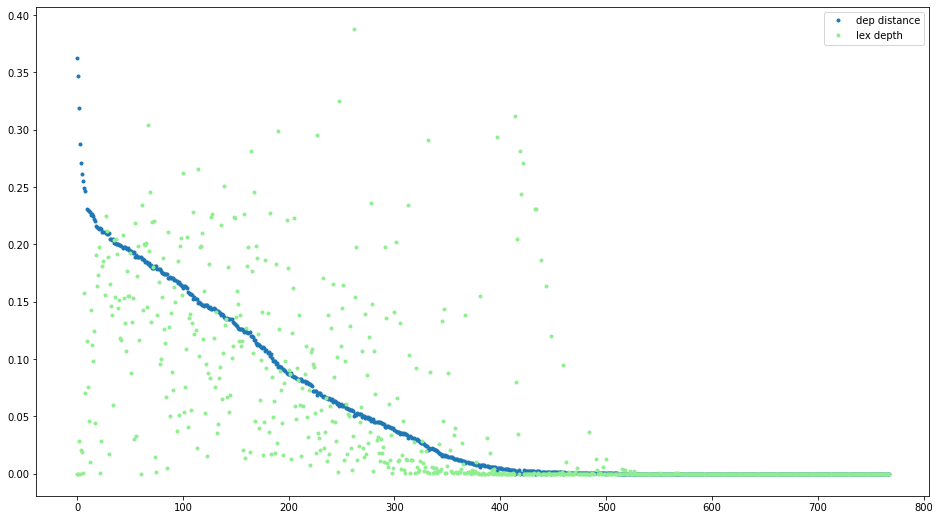

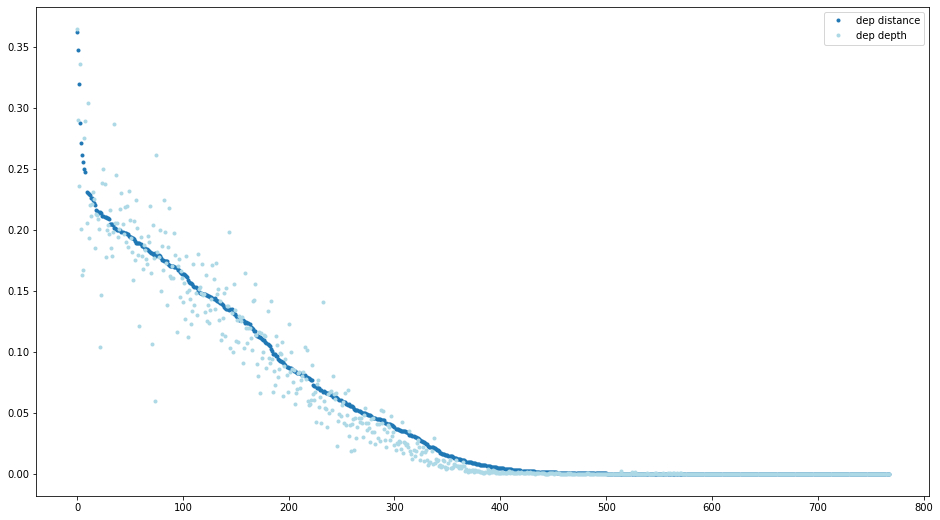

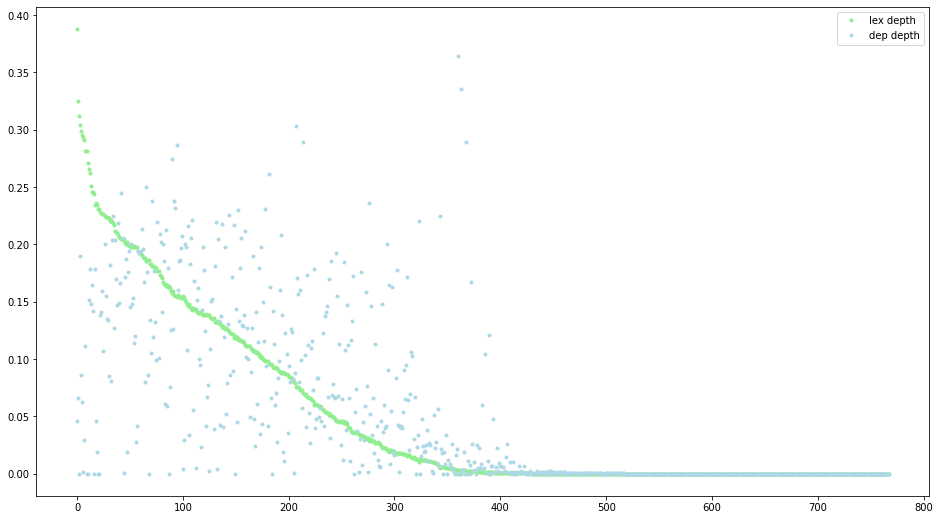

In [14]:
layer_idx = 6

ckpt = load_ckpt(layer_idx)
dep_distance_probe = ckpt.dep_distance.numpy().ravel()
lex_distance_probe = ckpt.lex_distance.numpy().ravel()
der_distance_probe = ckpt.der_distance.numpy().ravel()
dep_depth_probe = ckpt.dep_depth.numpy().ravel()
lex_depth_probe = ckpt.lex_depth.numpy().ravel()
der_depth_probe = ckpt.der_depth.numpy().ravel()

visualize_disentanglement([lex_distance_probe, dep_distance_probe, lex_depth_probe, dep_depth_probe], 
                              ['lex distance','dep distance', 'lex depth', 'dep depth'])

In [ ]:
O